### Imports and Setup

In [6]:
from pathlib import Path

import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.ticker import FormatStrFormatter, FuncFormatter
from sklearn.preprocessing import StandardScaler

import mvgl

sns.set_theme(context="paper", style="whitegrid", palette="Set2")
plt.style.use(Path(mvgl.ROOT_DIR, "notebooks", "style.txt"))

%config InlineBackend.figure_format='retina'

### Functions

In [2]:
def read_perfs(exp_file, methods, varying):
    performances = []
    for method in methods:
        for v in varying:
            save_path = Path(mvgl.ROOT_DIR, "data", "simulations", "outputs", exp_file(v))
            save_file = Path(save_path, f"{method}.csv")

            perf = pd.read_csv(save_file, index_col=0)
            perf["Varying"] = v
            performances.append(perf)

    return pd.concat(performances)

def get_best_perf(performances, metric):
    performances["index"] = np.arange(len(performances))
    grouped = performances.groupby(["Run", "Method", "Varying"], as_index=False)

    view_indices = []
    consensus_indices = []
    for i, group in grouped:
        view_perf = group[group["Graph"] == "view"]
        best_indx = np.argmax(view_perf[metric])
        view_indices.append(view_perf.iloc[best_indx]["index"])
        if i[1] in ["mvgl-l1", "mvgl-l2"]:
            consensus_indices.append(view_perf.iloc[best_indx]["index"] + 1) 
        elif i[1] == "mvgl-pw-l2":
            consensus_indices.append(view_perf.iloc[best_indx]["index"] + 1) # Mean
        elif i[1] == "mvgl-pw-l1":
            consensus_indices.append(view_perf.iloc[best_indx]["index"] + 2) # Median
        else:
            consensus_indices.append(view_perf.iloc[best_indx]["index"] + 2)

    view_perf = performances.iloc[view_indices, :]
    consensus_perf = performances.iloc[consensus_indices, :]
    return view_perf, consensus_perf

### Comparison to JEMGL

In [24]:
metric = "F1"
graph_model = "er"
methods = ["svgl", "jemgl-group", "jemgl-laplacian", "mvgl-l1", "mvgl-l2"]
n_views = np.arange(3, 7)

view_perf = {}
consensus_perf = {}
for fltr in ["gaussian", "heat", "tikhonov"]:
    exp_file = lambda v: f"exp1-{graph_model}-{v}-{fltr}"
    performances = read_perfs(exp_file, methods, n_views)
    performances = performances[performances["Varying"] == 6]
    view_perf[fltr], consensus_perf[fltr] = get_best_perf(performances, metric)

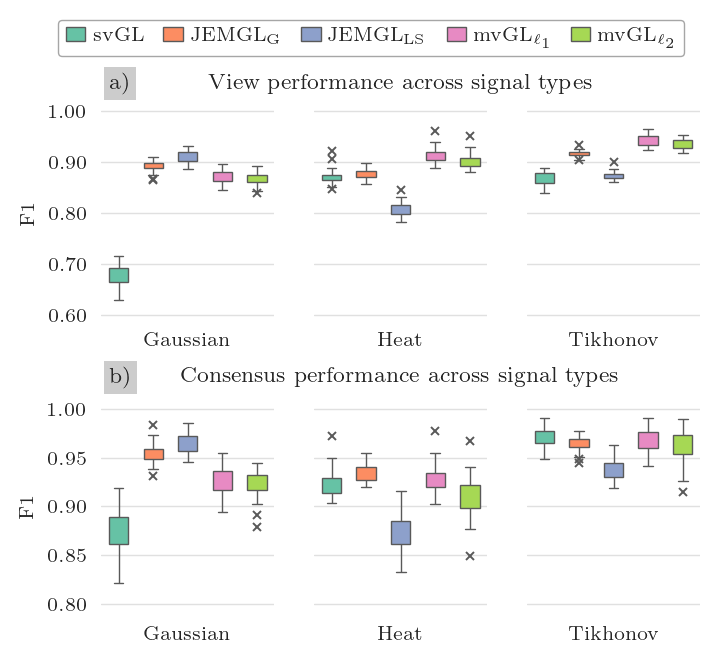

In [25]:
fig = plt.figure(figsize=(3.5, 3.2), constrained_layout=True)
gs = fig.add_gridspec(3, 3, height_ratios = (1, 8, 8))

lw = 0.5
fs = 3
hue_order = ["svgl", "jemgl-group", "jemgl-laplacian", "mvgl-l1", "mvgl-l2"]

######

ax = fig.add_subplot(gs[1, 0])
sns.boxplot(view_perf["gaussian"], x="Method", y="F1", hue="Method", ax=ax, 
            legend=True, gap=0.3, linewidth=lw, saturation=1,
            fliersize=fs, flierprops={"markeredgewidth": 0.7, "marker": "x"},
            medianprops={"linewidth": 0}, order=hue_order, hue_order=hue_order)

ax.set_xticklabels([])
ax.tick_params(axis="x", length=0)
ax.tick_params(axis="y", pad=0)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xlabel("Gaussian", labelpad=1)
ax.set_ylabel(r"F1")
ax.grid(axis="y", visible=True)
handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
ax.set_ylim([0.59, 1.01])
for side in ["top", "right", "bottom", "left"]:
    ax.spines[side].set_visible(False)

ax.annotate(r"a)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, 1.5), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

######

ax = fig.add_subplot(gs[1, 1])
sns.boxplot(view_perf["heat"], x="Method", y="F1", hue="Method", ax=ax, 
            gap=0.3, linewidth=lw, saturation=1, fliersize=fs, 
            flierprops={"markeredgewidth": 0.7, "marker": "x"},
            medianprops={"linewidth": 0}, order=hue_order, hue_order=hue_order)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis="x", length=0)
ax.set_xlabel("Heat", labelpad=1)
ax.set_ylabel("")
ax.grid(axis="y", visible=True)
ax.set_ylim([0.59, 1.01])
ax.set_title("View performance across signal types")
for side in ["top", "right", "bottom", "left"]:
    ax.spines[side].set_visible(False)

######

ax = fig.add_subplot(gs[1, 2])
sns.boxplot(view_perf["tikhonov"], x="Method", y="F1", hue="Method", ax=ax, 
            gap=0.3, linewidth=lw, saturation=1, fliersize=fs, 
            flierprops={"markeredgewidth": 0.7, "marker": "x"},
            medianprops={"linewidth": 0}, order=hue_order, hue_order=hue_order)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis="x", length=0)
ax.set_xlabel("Tikhonov", labelpad=1)
ax.set_ylabel("")
ax.grid(axis="y", visible=True)
ax.set_ylim([0.59, 1.01])
for side in ["top", "right", "bottom", "left"]:
    ax.spines[side].set_visible(False)

#####

ax = fig.add_subplot(gs[2, 0])
sns.boxplot(consensus_perf["gaussian"], x="Method", y="F1", hue="Method", ax=ax, 
            legend=True, gap=0.3, linewidth=lw, saturation=1,
            fliersize=fs, flierprops={"markeredgewidth": 0.7, "marker": "x"},
            medianprops={"linewidth": 0}, order=hue_order, hue_order=hue_order)

ax.set_xticklabels([])
ax.tick_params(axis="x", length=0)
ax.tick_params(axis="y", pad=0)
ax.set_xlabel("Gaussian", labelpad=1)
ax.set_ylabel(r"F1")
ax.grid(axis="y", visible=True)
handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
ax.set_ylim([0.79, 1.01])
for side in ["top", "right", "bottom", "left"]:
    ax.spines[side].set_visible(False)

ax.annotate(r"b)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, 1.5), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

######

ax = fig.add_subplot(gs[2, 1])
sns.boxplot(consensus_perf["heat"], x="Method", y="F1", hue="Method", ax=ax, 
            gap=0.3, linewidth=lw, saturation=1, fliersize=fs, 
            flierprops={"markeredgewidth": 0.7, "marker": "x"},
            medianprops={"linewidth": 0}, order=hue_order, hue_order=hue_order)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis="x", length=0)
ax.set_xlabel("Heat", labelpad=1)
ax.set_ylabel("")
ax.grid(axis="y", visible=True)
ax.set_ylim([0.79, 1.01])
ax.set_title("Consensus performance across signal types")
for side in ["top", "right", "bottom", "left"]:
    ax.spines[side].set_visible(False)

######

ax = fig.add_subplot(gs[2, 2])
sns.boxplot(consensus_perf["tikhonov"], x="Method", y="F1", hue="Method", ax=ax, 
            gap=0.3, linewidth=lw, saturation=1, fliersize=fs, 
            flierprops={"markeredgewidth": 0.7, "marker": "x"},
            medianprops={"linewidth": 0}, order=hue_order, hue_order=hue_order)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis="x", length=0)
ax.set_xlabel("Tikhonov", labelpad=1)
ax.set_ylabel("")
ax.grid(axis="y", visible=True)
ax.set_ylim([0.79, 1.01])
for side in ["top", "right", "bottom", "left"]:
    ax.spines[side].set_visible(False)

#####

ax = fig.add_subplot(gs[0, :])
labels = [r"$\textrm{svGL}$", r"$\textrm{JEMGL}_{\rm G}$", r"$\textrm{JEMGL}_{\rm LS}$", 
          r"$\textrm{mvGL}_{\ell_1}$", r"$\textrm{mvGL}_{\ell_2}$"]
legend = ax.legend(handles, labels, ncols=5, loc="center", bbox_to_anchor=[0.45, 0.5], 
                   handlelength=1, handletextpad=0.4, columnspacing=1)
ax.set_axis_off()
legend.get_frame().set_linewidth(0.5)
legend.get_frame().set_edgecolor("#909090")

#####

fig.get_layout_engine().set(w_pad=0.05)

fig_fname = Path(mvgl.ROOT_DIR, "reports", "figures", "jemgl_comparison.pdf")
fig.savefig(fig_fname, pad_inches=0.05)

### Comparison to JEMGL: Time Complexity

In [26]:
metric = "F1"
graph_model = "er"
fltr = "gaussian"
methods = ["svgl", "jemgl-group", "jemgl-laplacian", "mvgl-l1", "mvgl-l2"]
n_views = np.arange(3, 7)
n_nodes = np.arange(50, 201, 50)

view_perf = {}
consensus_perf = {}

exp_file = lambda v: f"exp1-{graph_model}-{v}-{fltr}"
performances = read_perfs(exp_file, methods, n_views)
view_perf["exp1"], consensus_perf["exp1"] = get_best_perf(performances, metric)

svgl_entries = view_perf["exp1"]["Method"] == "svgl"
view_perf["exp1"].loc[svgl_entries, "RunTime"] *= view_perf["exp1"].loc[svgl_entries, "Varying"]

exp_file = lambda v: f"exp4-{graph_model}-{v}-{fltr}"
performances = read_perfs(exp_file, methods, n_nodes)
view_perf["exp2"], consensus_perf["exp2"] = get_best_perf(performances, metric)

svgl_entries = view_perf["exp2"]["Method"] == "svgl"
view_perf["exp2"].loc[svgl_entries, "RunTime"] *= 6

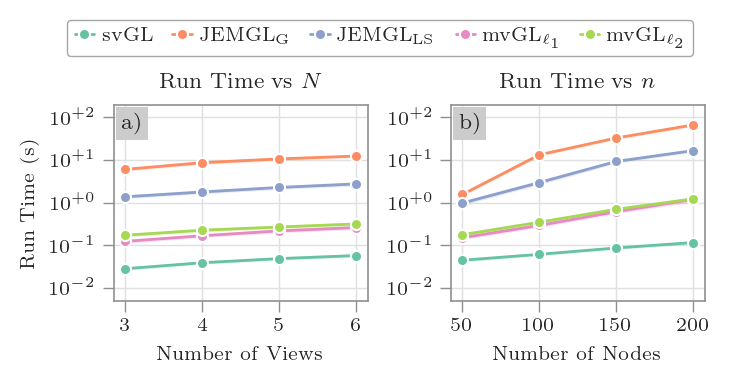

In [27]:
# this is the function the FuncFormatter will use
def mylogfmt(x,pos):
    logx = np.log10(x) # to get the exponent
    if logx < 0:
        # negative sign is added automatically  
        return u"$10^{{{:.0f}}}$".format(logx)
    else:
        # we need to explicitly add the positive sign
        return u"$10^{{+{:.0f}}}$".format(logx)

fig = plt.figure(figsize=(3.5, 1.8), constrained_layout=True)
gs = fig.add_gridspec(2, 2, height_ratios = (1, 8))

hue_order = ["svgl", "jemgl-group", "jemgl-laplacian", "mvgl-l1", "mvgl-l2"]

######

ax = fig.add_subplot(gs[1, 0])
sns.lineplot(view_perf["exp1"], x="Varying", y="RunTime", hue="Method", ax=ax, 
            legend=True, marker="o", markersize=4, linewidth=1, hue_order=hue_order)

handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
ax.set_yscale("log")
ax.set_ylim([0.5e-2, 2e+2])
ax.set_xticks([3, 4, 5, 6])
ax.yaxis.set_major_formatter(FuncFormatter(mylogfmt))
ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)
ax.set_title(r"Run Time vs $N$")
ax.set_xlabel("Number of Views")
ax.set_ylabel("Run Time (s)")

ax.annotate(r"a)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, -0.35), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))


#####

ax = fig.add_subplot(gs[1, 1])
sns.lineplot(view_perf["exp2"], x="Varying", y="RunTime", hue="Method", ax=ax, 
            legend=True, marker="o", markersize=4, linewidth=1, hue_order=hue_order)

handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
ax.set_yscale("log")
ax.set_ylim([0.5e-2, 2e+2])
ax.set_xticks([50, 100, 150, 200])
ax.set_ylabel("")
ax.set_xlabel("Number of Nodes")
ax.yaxis.set_major_formatter(FuncFormatter(mylogfmt))
ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)
ax.set_title(r"Run Time vs $n$")

ax.annotate(r"b)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, -0.35), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

#####

ax = fig.add_subplot(gs[0, :])
labels = [r"$\textrm{svGL}$", r"$\textrm{JEMGL}_{\rm G}$", r"$\textrm{JEMGL}_{\rm LS}$", 
          r"$\textrm{mvGL}_{\ell_1}$", r"$\textrm{mvGL}_{\ell_2}$"]
legend = ax.legend(handles, labels, ncols=5, loc="center", bbox_to_anchor=[0.45, 0.5], 
                   handlelength=1, handletextpad=0.4, columnspacing=1)
ax.set_axis_off()
legend.get_frame().set_linewidth(0.5)
legend.get_frame().set_edgecolor("#909090")

#####

fig.get_layout_engine().set(w_pad=0.025)

fig_fname = Path(mvgl.ROOT_DIR, "reports", "figures", "jemgl_comparison_time.pdf")
fig.savefig(fig_fname, pad_inches=0.05)

### Comparison to Pairwise mvGL

In [64]:
metric = "F1"
graph_model = "er"
methods = ["svgl", "mvgl-l1", "mvgl-l2", "mvgl-pw-l1", "mvgl-pw-l2"]
n_views = np.arange(3, 7)

view_perf = {}
consensus_perf = {}
for fltr in ["gaussian", "heat", "tikhonov"]:
    exp_file = lambda v: f"exp1-{graph_model}-{v}-{fltr}"
    performances = read_perfs(exp_file, methods, n_views)
    performances = performances[performances["Varying"] == 6]
    view_perf[fltr], consensus_perf[fltr] = get_best_perf(performances, metric)

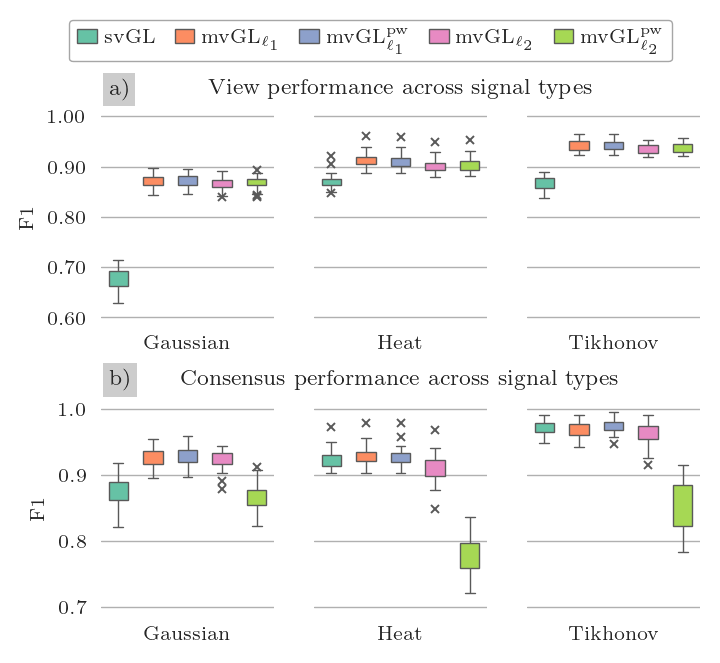

In [66]:
fig = plt.figure(figsize=(3.5, 3.2), constrained_layout=True)
gs = fig.add_gridspec(3, 3, height_ratios = (1, 8, 8))

lw = 0.5
fs = 3
hue_order = ["svgl", "mvgl-l1", "mvgl-pw-l1", "mvgl-l2", "mvgl-pw-l2"]

######

ax = fig.add_subplot(gs[1, 0])
sns.boxplot(view_perf["gaussian"], x="Method", y="F1", hue="Method", ax=ax, 
            legend=True, gap=0.3, linewidth=lw, saturation=1,
            fliersize=fs, flierprops={"markeredgewidth": 0.7, "marker": "x"},
            medianprops={"linewidth": 0}, order=hue_order, hue_order=hue_order)

ax.set_xticklabels([])
ax.tick_params(axis="x", length=0)
ax.tick_params(axis="y", pad=0)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xlabel("Gaussian", labelpad=1)
ax.set_ylabel(r"F1")
ax.grid(axis="y", visible=True)
handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
ax.set_ylim([0.59, 1.01])
for side in ["top", "right", "bottom", "left"]:
    ax.spines[side].set_visible(False)

ax.annotate(r"a)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, 1.5), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

######

ax = fig.add_subplot(gs[1, 1])
sns.boxplot(view_perf["heat"], x="Method", y="F1", hue="Method", ax=ax, 
            gap=0.3, linewidth=lw, saturation=1, fliersize=fs, 
            flierprops={"markeredgewidth": 0.7, "marker": "x"},
            medianprops={"linewidth": 0}, order=hue_order, hue_order=hue_order)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis="x", length=0)
ax.set_xlabel("Heat", labelpad=1)
ax.set_ylabel("")
ax.grid(axis="y", visible=True)
ax.set_ylim([0.59, 1.01])
ax.set_title("View performance across signal types")
for side in ["top", "right", "bottom", "left"]:
    ax.spines[side].set_visible(False)

######

ax = fig.add_subplot(gs[1, 2])
sns.boxplot(view_perf["tikhonov"], x="Method", y="F1", hue="Method", ax=ax, 
            gap=0.3, linewidth=lw, saturation=1, fliersize=fs, 
            flierprops={"markeredgewidth": 0.7, "marker": "x"},
            medianprops={"linewidth": 0}, order=hue_order, hue_order=hue_order)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis="x", length=0)
ax.set_xlabel("Tikhonov", labelpad=1)
ax.set_ylabel("")
ax.grid(axis="y", visible=True)
ax.set_ylim([0.59, 1.01])
for side in ["top", "right", "bottom", "left"]:
    ax.spines[side].set_visible(False)

#####

ax = fig.add_subplot(gs[2, 0])
sns.boxplot(consensus_perf["gaussian"], x="Method", y="F1", hue="Method", ax=ax, 
            legend=True, gap=0.3, linewidth=lw, saturation=1,
            fliersize=fs, flierprops={"markeredgewidth": 0.7, "marker": "x"},
            medianprops={"linewidth": 0}, order=hue_order, hue_order=hue_order)

ax.set_xticklabels([])
ax.tick_params(axis="x", length=0)
ax.tick_params(axis="y", pad=0)
ax.set_xlabel("Gaussian", labelpad=1)
ax.set_ylabel(r"F1")
ax.grid(axis="y", visible=True)
handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
ax.set_ylim([0.69, 1.01])
for side in ["top", "right", "bottom", "left"]:
    ax.spines[side].set_visible(False)

ax.annotate(r"b)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, 1.5), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

######

ax = fig.add_subplot(gs[2, 1])
sns.boxplot(consensus_perf["heat"], x="Method", y="F1", hue="Method", ax=ax, 
            gap=0.3, linewidth=lw, saturation=1, fliersize=fs, 
            flierprops={"markeredgewidth": 0.7, "marker": "x"},
            medianprops={"linewidth": 0}, order=hue_order, hue_order=hue_order)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis="x", length=0)
ax.set_xlabel("Heat", labelpad=1)
ax.set_ylabel("")
ax.grid(axis="y", visible=True)
ax.set_ylim([0.69, 1.01])
ax.set_title("Consensus performance across signal types")
for side in ["top", "right", "bottom", "left"]:
    ax.spines[side].set_visible(False)

######

ax = fig.add_subplot(gs[2, 2])
sns.boxplot(consensus_perf["tikhonov"], x="Method", y="F1", hue="Method", ax=ax, 
            gap=0.3, linewidth=lw, saturation=1, fliersize=fs, 
            flierprops={"markeredgewidth": 0.7, "marker": "x"},
            medianprops={"linewidth": 0}, order=hue_order, hue_order=hue_order)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis="x", length=0)
ax.set_xlabel("Tikhonov", labelpad=1)
ax.set_ylabel("")
ax.grid(axis="y", visible=True)
ax.set_ylim([0.69, 1.01])
for side in ["top", "right", "bottom", "left"]:
    ax.spines[side].set_visible(False)

#####

ax = fig.add_subplot(gs[0, :])
labels = [r"$\textrm{svGL}$", r"$\textrm{mvGL}_{\ell_1}$", r"$\textrm{mvGL}_{\ell_1}^{\rm pw}$",
          r"$\textrm{mvGL}_{\ell_2}$", r"$\textrm{mvGL}_{\ell_2}^{\rm pw}$"]
legend = ax.legend(handles, labels, ncols=5, loc="center", bbox_to_anchor=[0.45, 0.5], 
                   handlelength=1, handletextpad=0.4, columnspacing=1)
ax.set_axis_off()
legend.get_frame().set_linewidth(0.5)
legend.get_frame().set_edgecolor("#909090")

#####

fig.get_layout_engine().set(w_pad=0.05)

fig_fname = Path(mvgl.ROOT_DIR, "reports", "figures", "pairwise_comparison.pdf")
fig.savefig(fig_fname, pad_inches=0.05)

### Comparison to Pairwise mvGL: Time Complexity

In [28]:
metric = "F1"
graph_model = "er"
fltr = "gaussian"
methods = ["svgl", "mvgl-l1", "mvgl-l2", "mvgl-pw-l1", "mvgl-pw-l2"]
n_views = np.arange(3, 7)
n_nodes = np.arange(50, 201, 50)

view_perf = {}
consensus_perf = {}

exp_file = lambda v: f"exp1-{graph_model}-{v}-{fltr}"
performances = read_perfs(exp_file, methods, n_views)
view_perf["exp1"], consensus_perf["exp1"] = get_best_perf(performances, metric)

svgl_entries = view_perf["exp1"]["Method"] == "svgl"
view_perf["exp1"].loc[svgl_entries, "RunTime"] *= view_perf["exp1"].loc[svgl_entries, "Varying"]

exp_file = lambda v: f"exp4-{graph_model}-{v}-{fltr}"
performances = read_perfs(exp_file, methods, n_nodes)
view_perf["exp2"], consensus_perf["exp2"] = get_best_perf(performances, metric)

svgl_entries = view_perf["exp2"]["Method"] == "svgl"
view_perf["exp2"].loc[svgl_entries, "RunTime"] *= 6

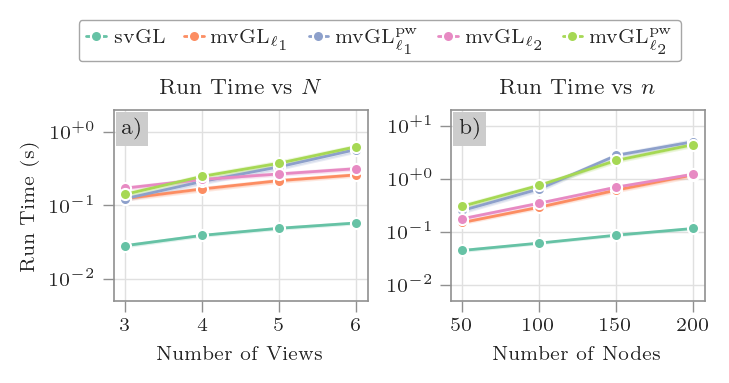

In [29]:
# this is the function the FuncFormatter will use
def mylogfmt(x,pos):
    logx = np.log10(x) # to get the exponent
    if logx < 0:
        # negative sign is added automatically  
        return u"$10^{{{:.0f}}}$".format(logx)
    else:
        # we need to explicitly add the positive sign
        return u"$10^{{+{:.0f}}}$".format(logx)

fig = plt.figure(figsize=(3.5, 1.8), constrained_layout=True)
gs = fig.add_gridspec(2, 2, height_ratios = (1, 8))

hue_order = ["svgl", "mvgl-l1", "mvgl-pw-l1", "mvgl-l2", "mvgl-pw-l2", ]

######

ax = fig.add_subplot(gs[1, 0])
sns.lineplot(view_perf["exp1"], x="Varying", y="RunTime", hue="Method", ax=ax, 
            legend=True, marker="o", markersize=4, linewidth=1, hue_order=hue_order)

handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
ax.set_yscale("log")
ax.set_ylim([0.5e-2, 2e+0])
ax.set_xticks([3, 4, 5, 6])
ax.yaxis.set_major_formatter(FuncFormatter(mylogfmt))
ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)
ax.set_title(r"Run Time vs $N$")
ax.set_xlabel("Number of Views")
ax.set_ylabel("Run Time (s)")

ax.annotate(r"a)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, -0.35), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))


#####

ax = fig.add_subplot(gs[1, 1])
sns.lineplot(view_perf["exp2"], x="Varying", y="RunTime", hue="Method", ax=ax, 
            legend=True, marker="o", markersize=4, linewidth=1, hue_order=hue_order)

handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
ax.set_yscale("log")
ax.set_ylim([0.5e-2, 2e+1])
ax.set_xticks([50, 100, 150, 200])
ax.set_ylabel("")
ax.set_xlabel("Number of Nodes")
ax.yaxis.set_major_formatter(FuncFormatter(mylogfmt))
ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)
ax.set_title(r"Run Time vs $n$")

ax.annotate(r"b)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, -0.35), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

#####

ax = fig.add_subplot(gs[0, :])
labels = [r"$\textrm{svGL}$", r"$\textrm{mvGL}_{\ell_1}$", r"$\textrm{mvGL}_{\ell_1}^{\rm pw}$",
          r"$\textrm{mvGL}_{\ell_2}$", r"$\textrm{mvGL}_{\ell_2}^{\rm pw}$"]
legend = ax.legend(handles, labels, ncols=5, loc="center", bbox_to_anchor=[0.45, 0.5], 
                   handlelength=1, handletextpad=0.4, columnspacing=1)
ax.set_axis_off()
legend.get_frame().set_linewidth(0.5)
legend.get_frame().set_edgecolor("#909090")

#####

fig.get_layout_engine().set(w_pad=0.025)

fig_fname = Path(mvgl.ROOT_DIR, "reports", "figures", "pairwise_comparison_time.pdf")
fig.savefig(fig_fname, pad_inches=0.05)

### L1-norm vs L2-norm

In [366]:
metric = "F1"
graph_model = "er"
n_edges_to_add = 100
n_edges_to_remove = 100
methods = ["mvgl-l1", "mvgl-l2"]
n_views_to_change = np.arange(1, 6)

exp_file = lambda v: f"revision-exp1-{graph_model}-{n_edges_to_add}-" + \
    f"{n_edges_to_remove}-{v}"
performances = read_perfs(exp_file, methods, n_views_to_change)
view_perf, consensus_perf = get_best_perf(performances, metric)

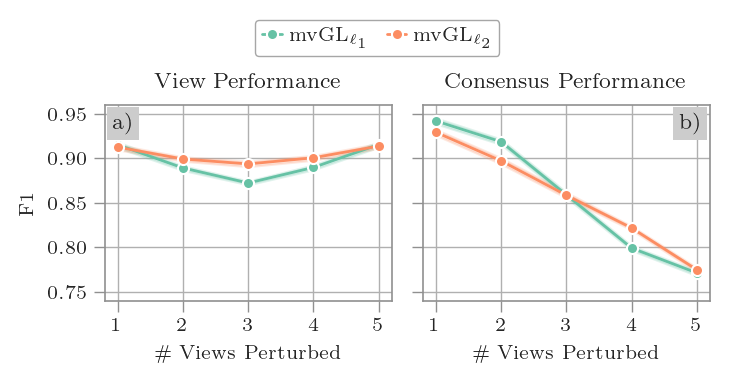

In [373]:
fig = plt.figure(figsize=(3.5, 1.8), constrained_layout=True)
gs = fig.add_gridspec(2, 2, height_ratios = (1, 8))

######

ax = fig.add_subplot(gs[1, 0])
sns.lineplot(view_perf, x="Varying", y="F1", hue="Method", ax=ax, 
            legend=True, marker="o", markersize=4, linewidth=1)

handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
ax.set_ylim([0.74, 0.96])
ax.set_xticks(n_views_to_change)
ax.set_title("View Performance")
ax.set_xlabel(r"\# Views Perturbed")
ax.set_yticks(np.arange(0.75, 0.96, 0.05))
ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)

ax.annotate(r"a)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, -0.35), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

######

ax = fig.add_subplot(gs[1, 1])
sns.lineplot(consensus_perf, x="Varying", y="F1", hue="Method", ax=ax, 
            legend=True, marker="o", markersize=4, linewidth=1)

handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
ax.set_ylim([0.74, 0.96])
ax.set_ylabel("")
ax.set_yticklabels([])
ax.set_xlabel(r"\# Views Perturbed")
ax.set_xticks(n_views_to_change)
ax.set_title("Consensus Performance")
ax.set_yticks(np.arange(0.75, 0.96, 0.05))
ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)

ax.annotate(r"b)", xy=(1, 1), xycoords='axes fraction',
            xytext=(-1.4, -0.35), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

#####

ax = fig.add_subplot(gs[0, :])
labels = [r"$\textrm{mvGL}_{\ell_1}$", r"$\textrm{mvGL}_{\ell_2}$"]
legend = ax.legend(handles, labels, ncols=5, loc="center", bbox_to_anchor=[0.45, 0.5], 
                   handlelength=1, handletextpad=0.4, columnspacing=1)
ax.set_axis_off()
legend.get_frame().set_linewidth(0.5)
legend.get_frame().set_edgecolor("#909090")

#####

fig.get_layout_engine().set(w_pad=0.025)

fig_fname = Path(mvgl.ROOT_DIR, "reports", "figures", "l1_vs_l2.pdf")
fig.savefig(fig_fname, pad_inches=0.05)

### Metric comparison

In [38]:
metric = "F1"
graph_model = "er"
methods = ["svgl", "jemgl-group", "jemgl-laplacian", "mvgl-pw-l1", "mvgl-pw-l2", "mvgl-l1", "mvgl-l2"]
n_views = np.arange(3, 7)

view_perf = {}
consensus_perf = {}
for fltr in ["gaussian", "heat", "tikhonov"]:
    exp_file = lambda v: f"exp1-{graph_model}-{v}-{fltr}"
    performances = read_perfs(exp_file, methods, n_views)
    performances = performances[performances["Varying"] == 6]
    view_perf[fltr], consensus_perf[fltr] = get_best_perf(performances, metric)

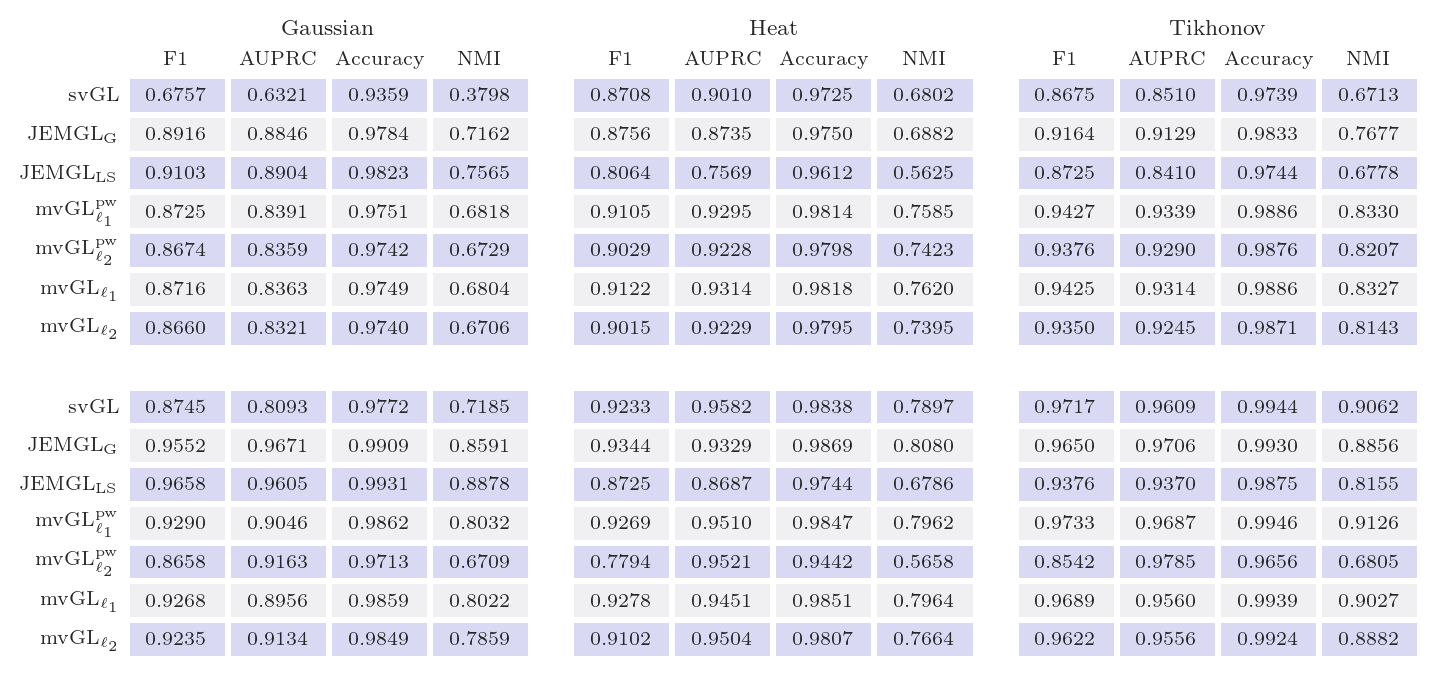

In [48]:
def aggregate_perfs(perf): 
    
    agg_df = {"method": [], "metric": [], "mean": [], "std": []}
    grouped = perf.groupby("Method", sort=False)
    for method, group in grouped:
        for metric in ["F1", "AUPRC", "Accuracy", "NMI"]:
            agg_df["method"].append(method)
            agg_df["metric"].append(metric)
            agg_df["mean"].append(group[metric].mean())
            agg_df["std"].append(group[metric].std())

    agg_df = pd.DataFrame(agg_df)
    agg_df = agg_df.pivot(index="method", columns="metric", values="mean")
    return agg_df.loc[methods, ["F1", "AUPRC", "Accuracy", "NMI"]]

#####

fig = plt.figure(figsize=(7.2, 3.4), constrained_layout=True)
gs = fig.add_gridspec(2, 3)

method_labels = [
    r"$\textrm{svGL}$", r"$\textrm{JEMGL}_{\rm G}$", r"$\textrm{JEMGL}_{\rm LS}$", 
    r"$\textrm{mvGL}_{\ell_1}^{\rm pw}$", r"$\textrm{mvGL}_{\ell_2}^{\rm pw}$", 
    r"$\textrm{mvGL}_{\ell_1}$", r"$\textrm{mvGL}_{\ell_2}$",
]

#####

ax = fig.add_subplot(gs[0, 0])
agg_df = aggregate_perfs(view_perf["gaussian"])
color_df = np.zeros(shape=(len(method_labels), 4))
color_df[list(range(0, len(method_labels), 2)), :] = 0.1
color_df = pd.DataFrame(color_df, index=agg_df.index, columns=agg_df.columns)
sns.heatmap(color_df, vmin=0, vmax=1, cmap=sns.color_palette("light:b", as_cmap=True), 
            cbar=False, annot=agg_df, fmt=".4f", annot_kws={"size": 7}, ax=ax, 
            linewidths=1.5)

ax.set_ylabel("")
ax.set_yticklabels(method_labels)
ax.tick_params(axis="y", pad=-2)

ax.set_xlabel("")
ax.tick_params(axis="x", pad=-2, labeltop=True, labelbottom=False)

ax.set_title("Gaussian")

#####

ax = fig.add_subplot(gs[0, 1])
agg_df = aggregate_perfs(view_perf["heat"])
sns.heatmap(color_df, vmin=0, vmax=1, cmap=sns.color_palette("light:b", as_cmap=True), 
            cbar=False, annot=agg_df, fmt=".4f", annot_kws={"size": 7}, ax=ax, 
            linewidths=1.5)

ax.set_ylabel("")
ax.set_yticklabels([])
ax.tick_params(axis="y", pad=-2)

ax.set_xlabel("")
ax.tick_params(axis="x", pad=-2, labeltop=True, labelbottom=False)

ax.set_title("Heat")

#####

ax = fig.add_subplot(gs[0, 2])
agg_df = aggregate_perfs(view_perf["tikhonov"])
sns.heatmap(color_df, vmin=0, vmax=1, cmap=sns.color_palette("light:b", as_cmap=True), 
            cbar=False, annot=agg_df, fmt=".4f", annot_kws={"size": 7}, ax=ax, 
            linewidths=1.5)

ax.set_ylabel("")
ax.set_yticklabels([])
ax.tick_params(axis="y", pad=-2)

ax.set_xlabel("")
ax.tick_params(axis="x", pad=-2, labeltop=True, labelbottom=False)

ax.set_title("Tikhonov")

#####

ax = fig.add_subplot(gs[1, 0])
agg_df = aggregate_perfs(consensus_perf["gaussian"])
color_df = np.zeros(shape=(len(method_labels), 4))
color_df[list(range(0, len(method_labels), 2)), :] = 0.1
color_df = pd.DataFrame(color_df, index=agg_df.index, columns=agg_df.columns)
sns.heatmap(color_df, vmin=0, vmax=1, cmap=sns.color_palette("light:b", as_cmap=True), 
            cbar=False, annot=agg_df, fmt=".4f", annot_kws={"size": 7}, ax=ax, 
            linewidths=1.5)

ax.set_ylabel("")
ax.set_yticklabels(method_labels)
ax.tick_params(axis="y", pad=-2)

ax.set_xlabel("")
ax.tick_params(axis="x", pad=-2, labeltop=False, labelbottom=False)

# ax.set_title("Gaussian")

#####

ax = fig.add_subplot(gs[1, 1])
agg_df = aggregate_perfs(consensus_perf["heat"]).to_numpy()
sns.heatmap(color_df, vmin=0, vmax=1, cmap=sns.color_palette("light:b", as_cmap=True), 
            cbar=False, annot=agg_df, fmt=".4f", annot_kws={"size": 7}, ax=ax, 
            linewidths=1.5)

ax.set_ylabel("")
ax.set_yticklabels([])
ax.tick_params(axis="y", pad=-2)

ax.set_xlabel("")
ax.tick_params(axis="x", pad=-2, labeltop=False, labelbottom=False)

# ax.set_title("Heat")

#####

ax = fig.add_subplot(gs[1, 2])
agg_df = aggregate_perfs(consensus_perf["tikhonov"])
sns.heatmap(color_df, vmin=0, vmax=1, cmap=sns.color_palette("light:b", as_cmap=True), 
            cbar=False, annot=agg_df, fmt=".4f", annot_kws={"size": 7}, ax=ax, 
            linewidths=1.5)

ax.set_ylabel("")
ax.set_yticklabels([])
ax.tick_params(axis="y", pad=-2)

ax.set_xlabel("")
ax.tick_params(axis="x", pad=-2, labeltop=False, labelbottom=False)


# ax.set_title("Tikhonov")

#####

fig.get_layout_engine().set(w_pad=0.1, h_pad=0.1)

fig_fname = Path(mvgl.ROOT_DIR, "reports", "figures", "metric-comparison.pdf")
fig.savefig(fig_fname, pad_inches=0.05)

### EEG Ground-Truth based comparison

In [26]:
import mvgl.graphlearning
import mvgl.graphlearning.metrics


def get_graph_all_fname(density):
    fname = Path(mvgl.ROOT_DIR, "data", "eeg", "graphs", "svgl", "all", f"density_{density:.2f}")
    return Path(fname, "adjacencies.npz")

def get_graph_fname(method, frac_trials, density, similarity=None):
    fname = Path(mvgl.ROOT_DIR, "data", "eeg", "graphs", method, f"frac_trials_{frac_trials:.2f}", 
                 f"density_{density:.2f}")
    if similarity:
        fname = Path(fname, f"similarity_{similarity:.2f}")

    return Path(fname, "adjacencies.npz")

gt_methods = ["svgl", "svgl_all"]
methods = ["svgl", "mvgl_l1"]
n_subjects = 20
n_electrodes = 64

# Fraction of trials used during learning
data_fractions = np.arange(1, 9)*0.05
density_hats = np.arange(5, 26)*0.02
density_gts = np.arange(2, 7)*0.05

perf_df = {"Method": [], "Frac": [], "Similarity": [], "F1": [], 
           "Density": [], "GTDensity": [], "GTMethod": []}

for gt_method in gt_methods:
    for density_gt in density_gts:

        # Load "ground truth"
        if gt_method == "svgl_all":
            fname = get_graph_all_fname(density_gt)
            with np.load(fname) as X:
                Wns = X["views"]
                gt = [Wns[np.triu_indices(n_electrodes, k=1)]
                        for i in range(n_subjects)]
        else:
            gt_sim = 0.75 if gt_method == "mvgl_l1" else None 
            fname = get_graph_fname(gt_method, 1.0, density_gt, gt_sim)
        
            with np.load(fname) as X:
                Wns = X["views"]
                gt = [Wns[:, :, i].squeeze()[np.triu_indices(n_electrodes, k=1)]
                        for i in range(n_subjects)]

        for method in methods:
            for frac in data_fractions:
                for density in density_hats:
                    similarity = None if method == "svgl" else 0.75

                    with np.load(get_graph_fname(method, frac, density, similarity)) as X:

                        Wns = X["views"]
                        wns = [Wns[:, :, i].squeeze()[np.triu_indices(n_electrodes, k=1)]
                            for i in range(n_subjects)]
                        
                        if method == "mvgl_l1":
                            Wc = X["consensus"]
                            wc = Wc[np.triu_indices(n_electrodes, k=1)]
                        elif method == "svgl":
                            wc = np.median(wns, axis=0)
                    
                    mean_sim = 0
                    mean_f1 = 0
                    for i in range(n_subjects):
                        sims = mvgl.graphlearning.metrics.correlation(wns[i], wns)
                        mean_sim += (np.sum(sims) - sims[i])/(n_subjects-1)
                        mean_f1 += mvgl.graphlearning.metrics.f1(gt[i], wns[i])

                    perf_df["GTMethod"].append(gt_method)
                    perf_df["GTDensity"].append(density_gt)
                    perf_df["Method"].append(method)
                    perf_df["Frac"].append(frac)
                    perf_df["Density"].append(density)
                        
                    perf_df["Similarity"].append(mean_sim/n_subjects)
                    perf_df["F1"].append(mean_f1/n_subjects)
                    
                    perf_df["GTMethod"].append(gt_method)
                    perf_df["GTDensity"].append(density_gt)
                    perf_df["Method"].append(method + "(C)")
                    perf_df["Frac"].append(frac)
                    perf_df["Density"].append(density)

                    mean_f1 = 0
                    for i in range(n_subjects):
                        mean_f1 += mvgl.graphlearning.metrics.f1(gt[i], wc)
                            
                    perf_df["Similarity"].append(None)
                    perf_df["F1"].append(mean_f1/n_subjects)



perf_df = pd.DataFrame(perf_df)

In [45]:
perf_df["GTDensity"].unique()

array([0.1 , 0.15, 0.2 , 0.25, 0.3 ])

In [51]:
(np.abs(perf_df["GTDensity"] - 0.15) < 1e-8).sum()

1344

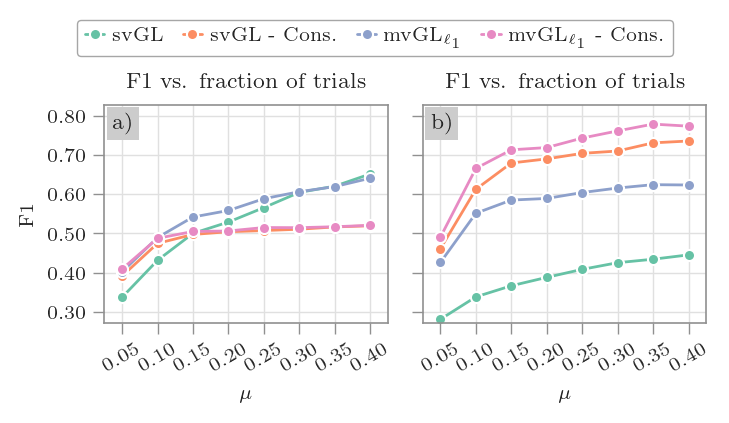

In [57]:
# Load the results to plot
# perf_file = Path(mvgl.ROOT_DIR, "data", "eeg", "gt_based_performances.csv")
# perf_df = pd.read_csv(perf_file, index_col=0)

# We constructed "ground-truth" with different densities, we need to pick one
gt_density = 0.15

fig = plt.figure(figsize=(3.5, 2.0), constrained_layout=True)
gs = fig.add_gridspec(2, 2, height_ratios = (1, 8))

hue_order = ["svgl", "svgl(C)", "mvgl_l1", "mvgl_l1(C)"]

#####

ax = fig.add_subplot(gs[1, 0])

perf_df_case = perf_df[
    ((perf_df["GTDensity"] - gt_density).abs() < 1e-8) & (perf_df["GTMethod"] == "svgl")
]
perf_df_case = perf_df_case.loc[
    perf_df_case.groupby(["Method", "Frac"])["F1"].idxmax()
]
sns.lineplot(perf_df_case, x="Frac", y="F1", hue="Method", ax=ax, 
            legend=True, marker="o", markersize=4, linewidth=1, hue_order=hue_order)

handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
ax.set_xlim([0.025, 0.425])
ax.set_ylim([0.27, 0.83])
ax.set_yticks(np.arange(0.3, 0.81, 0.1))
ax.set_xticks(np.arange(0.05, 0.41, 0.05))
ax.set_title("F1 vs. fraction of trials")
ax.set_xlabel(r"$\mu$")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2, labelrotation=30)

ax.annotate(r"a)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, -0.35), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

#####

ax = fig.add_subplot(gs[1, 1])

perf_df_case = perf_df[
   ((perf_df["GTDensity"] - gt_density).abs() < 1e-8) & (perf_df["GTMethod"] == "svgl_all")
]
perf_df_case = perf_df_case.loc[
    perf_df_case.groupby(["Method", "Frac"])["F1"].idxmax()
]
sns.lineplot(perf_df_case, x="Frac", y="F1", hue="Method", ax=ax, 
            legend=False, marker="o", markersize=4, linewidth=1, hue_order=hue_order)

ax.set_xlim([0.025, 0.425])
ax.set_ylim([0.27, 0.83])
ax.set_ylabel("")
ax.set_yticks(np.arange(0.3, 0.81, 0.1))
ax.set_xticks(np.arange(0.05, 0.41, 0.05))
ax.set_title("F1 vs. fraction of trials")
ax.set_xlabel(r"$\mu$")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2, labelrotation=30)
ax.set_yticklabels([])

ax.annotate(r"b)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, -0.35), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

####

ax = fig.add_subplot(gs[0, :])
labels = [r"$\textrm{svGL}$", r"$\textrm{svGL}$ - Cons.", r"$\textrm{mvGL}_{\ell_1}$", r"$\textrm{mvGL}_{\ell_1}$ - Cons."]
legend = ax.legend(handles, labels, ncols=5, loc="center", bbox_to_anchor=[0.45, 0.5], 
                   handlelength=1, handletextpad=0.4, columnspacing=1)
ax.set_axis_off()
legend.get_frame().set_linewidth(0.5)
legend.get_frame().set_edgecolor("#909090")

#####

fig.get_layout_engine().set(w_pad=0.025)

fig_fname = Path(mvgl.ROOT_DIR, "reports", "figures", "eeg_gt_based_comparison.pdf")
fig.savefig(fig_fname, pad_inches=0.05)

In [36]:
(perf_df["GTDensity"] == gt_density).sum()

0

### Parameter Sensitivity

In [58]:
metric = "F1"
graph_model = "er"
fltr = "gaussian"
methods = ["svgl", "mvgl-l1", "mvgl-l2"]
n_views = np.arange(3, 7)
n_signals = np.arange(200, 501, 100)
data_noise = np.arange(0.1, 0.41, 0.1)
perturbations = np.arange(0.05, 0.21, 0.05)

view_perf = {}
consensus_perf = {}

exp_file = lambda v: f"exp1-{graph_model}-{v}-{fltr}"
performances = read_perfs(exp_file, methods, n_views)
view_perf["exp1"], consensus_perf["exp1"] = get_best_perf(performances, metric)

exp_file = lambda v: f"exp2-{graph_model}-{v}-{fltr}"
performances = read_perfs(exp_file, methods, n_signals)
view_perf["exp2"], consensus_perf["exp2"] = get_best_perf(performances, metric)

exp_file = lambda v: f"exp3-{graph_model}-{v:.2f}-{fltr}"
performances = read_perfs(exp_file, methods, data_noise)
view_perf["exp3"], consensus_perf["exp3"] = get_best_perf(performances, metric)

exp_file = lambda v: f"revision-exp3-{graph_model}-{v:.2f}-{fltr}"
performances = read_perfs(exp_file, methods, perturbations)
view_perf["exp4"], consensus_perf["exp4"] = get_best_perf(performances, metric)

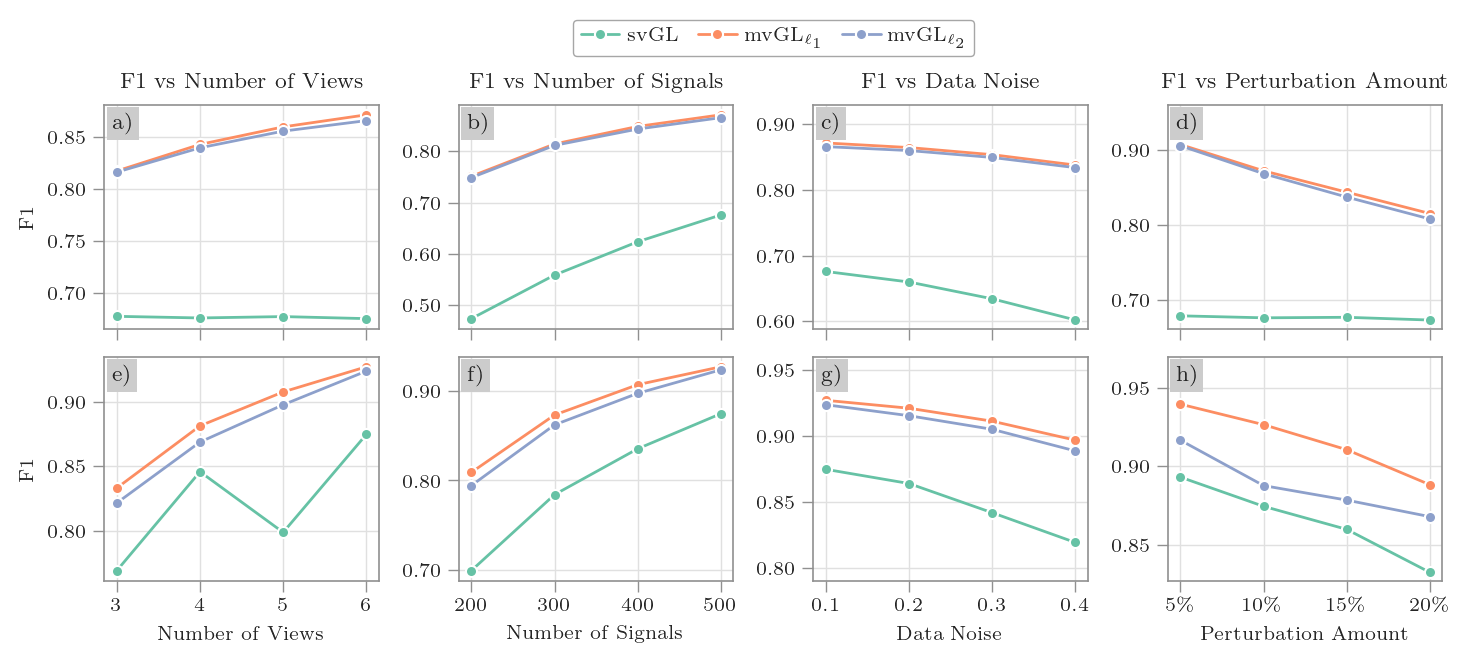

In [7]:
fig = plt.figure(figsize=(7.2, 3.2), constrained_layout=True)
gs = fig.add_gridspec(3, 4, height_ratios = (1, 8, 8))

hue_order = ["svgl", "mvgl-l1", "mvgl-l2"]
plot_inset = False

######

ax = fig.add_subplot(gs[1, 0])
sns.lineplot(view_perf["exp1"], x="Varying", y=metric, hue="Method", ax=ax, 
            legend=True, marker="o", markersize=4, linewidth=1, hue_order=hue_order, 
            errorbar=None)

handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)
ax.set_title(r"F1 vs Number of Views")
ax.set_xlabel("")
ax.set_ylabel("F1")
ax.set_xticklabels([])
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax.annotate(r"a)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, -0.35), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

if plot_inset:
    axin = ax.inset_axes((0.48, 0.15, 0.5, 0.5))
    sns.lineplot(view_perf["exp1"], x="Varying", y=metric, hue="Method", ax=axin, 
                legend=False, marker="o", markersize=3, linewidth=1,
                hue_order=["mvgl-l1", "mvgl-l2"], errorbar=None,
                palette=sns.color_palette("Set2")[1:3])
    axin.grid(False)
    axin.set_xlabel("")
    axin.set_ylabel("")
    axin.set_xticklabels([])
    axin.set_yticklabels([])

#####

ax = fig.add_subplot(gs[1, 1])
sns.lineplot(view_perf["exp2"], x="Varying", y=metric, hue="Method", ax=ax, 
            legend=False, marker="o", markersize=4, linewidth=1, hue_order=hue_order, 
            errorbar=None)

ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)
ax.set_title(r"F1 vs Number of Signals")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax.annotate(r"b)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, -0.35), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

if plot_inset:
    axin = ax.inset_axes((0.48, 0.02, 0.5, 0.5))
    sns.lineplot(view_perf["exp2"], x="Varying", y=metric, hue="Method", ax=axin, 
                legend=False, marker="o", markersize=3, linewidth=1,
                hue_order=["mvgl-l1", "mvgl-l2"], errorbar=None,
                palette=sns.color_palette("Set2")[1:3])
    axin.grid(False)
    axin.set_xlabel("")
    axin.set_ylabel("")
    axin.set_xticklabels([])
    axin.set_yticklabels([])
    

    start, end = ax.get_ylim()
    ax.set_ylim([0.35, end])


#####

ax = fig.add_subplot(gs[1, 2])
sns.lineplot(view_perf["exp3"], x="Varying", y=metric, hue="Method", ax=ax, 
            legend=False, marker="o", markersize=4, linewidth=1, hue_order=hue_order,
            errorbar=None)

ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)
ax.set_title(r"F1 vs Data Noise")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
start, end = ax.get_ylim()
ax.set_ylim([start, 0.93])
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax.annotate(r"c)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, -0.35), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

if plot_inset:
    axin = ax.inset_axes((0.48, 0.2, 0.5, 0.5))
    sns.lineplot(view_perf["exp3"], x="Varying", y=metric, hue="Method", ax=axin, 
                legend=False, marker="o", markersize=3, linewidth=1,
                hue_order=["mvgl-l1", "mvgl-l2"], errorbar=None,
                palette=sns.color_palette("Set2")[1:3])
    axin.grid(False)
    axin.set_xlabel("")
    axin.set_ylabel("")
    axin.set_xticklabels([])
    axin.set_yticklabels([])

#####

ax = fig.add_subplot(gs[1, 3])
sns.lineplot(view_perf["exp4"], x="Varying", y=metric, hue="Method", ax=ax, 
            legend=False, marker="o", markersize=4, linewidth=1, hue_order=hue_order,
            errorbar=None)

ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)
ax.set_title(r"F1 vs Perturbation Amount")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
start, end = ax.get_ylim()
ax.set_ylim([start, 0.96])
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax.annotate(r"d)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, -0.35), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

if plot_inset:
    axin = ax.inset_axes((0.02, 0.15, 0.5, 0.5))
    sns.lineplot(view_perf["exp4"], x="Varying", y=metric, hue="Method", ax=axin, 
                legend=False, marker="o", markersize=3, linewidth=1,
                hue_order=["mvgl-l1", "mvgl-l2"], errorbar=None,
                palette=sns.color_palette("Set2")[1:3])
    axin.grid(False)
    axin.set_xlabel("")
    axin.set_ylabel("")
    axin.set_xticklabels([])
    axin.set_yticklabels([])

##### 

ax = fig.add_subplot(gs[2, 0])
sns.lineplot(consensus_perf["exp1"], x="Varying", y=metric, hue="Method", ax=ax, 
            legend=True, marker="o", markersize=4, linewidth=1, hue_order=hue_order,
            errorbar=None)

handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)
ax.set_xlabel("Number of Views")
ax.set_ylabel("F1")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax.annotate(r"e)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, -0.35), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

#####

ax = fig.add_subplot(gs[2, 1])
sns.lineplot(consensus_perf["exp2"], x="Varying", y=metric, hue="Method", ax=ax, 
            legend=False, marker="o", markersize=4, linewidth=1, hue_order=hue_order, 
            errorbar=None)

ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)
ax.set_xlabel("Number of Signals")
ax.set_ylabel("")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax.annotate(r"f)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, -0.35), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

#####

ax = fig.add_subplot(gs[2, 2])
sns.lineplot(consensus_perf["exp3"], x="Varying", y=metric, hue="Method", ax=ax, 
            legend=False, marker="o", markersize=4, linewidth=1, hue_order=hue_order, 
            errorbar=None)

ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)
ax.set_xlabel("Data Noise")
ax.set_ylabel("")
ax.set_ylim([0.79, 0.96])
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax.annotate(r"g)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, -0.35), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

#####

ax = fig.add_subplot(gs[2, 3])
sns.lineplot(consensus_perf["exp4"], x="Varying", y=metric, hue="Method", ax=ax, 
            legend=False, marker="o", markersize=4, linewidth=1, hue_order=hue_order,
            errorbar=None)

ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)
ax.set_xlabel("Perturbation Amount")
ax.set_ylabel("")
ax.set_xticks(np.arange(0.05, 0.21, 0.05), labels=[f"{i}\%" for i in range(5, 21, 5)])
start, end = ax.get_ylim()
ax.set_ylim([start, 0.97])
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


ax.annotate(r"h)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, -0.35), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

#####

ax = fig.add_subplot(gs[0, :])
labels = [r"$\textrm{svGL}$", 
          r"$\textrm{mvGL}_{\ell_1}$", r"$\textrm{mvGL}_{\ell_2}$"]
legend = ax.legend(handles, labels, ncols=5, loc="center", bbox_to_anchor=[0.5, 0.5], 
                   handlelength=2, handletextpad=0.4, columnspacing=1)
ax.set_axis_off()
legend.get_frame().set_linewidth(0.5)
legend.get_frame().set_edgecolor("#909090")

#####

fig.get_layout_engine().set(w_pad=0.025)

fig_fname = Path(mvgl.ROOT_DIR, "reports", "figures", "parameter_sensitivity.pdf")
fig.savefig(fig_fname, pad_inches=0.05)

Parameter sensitivity for response:

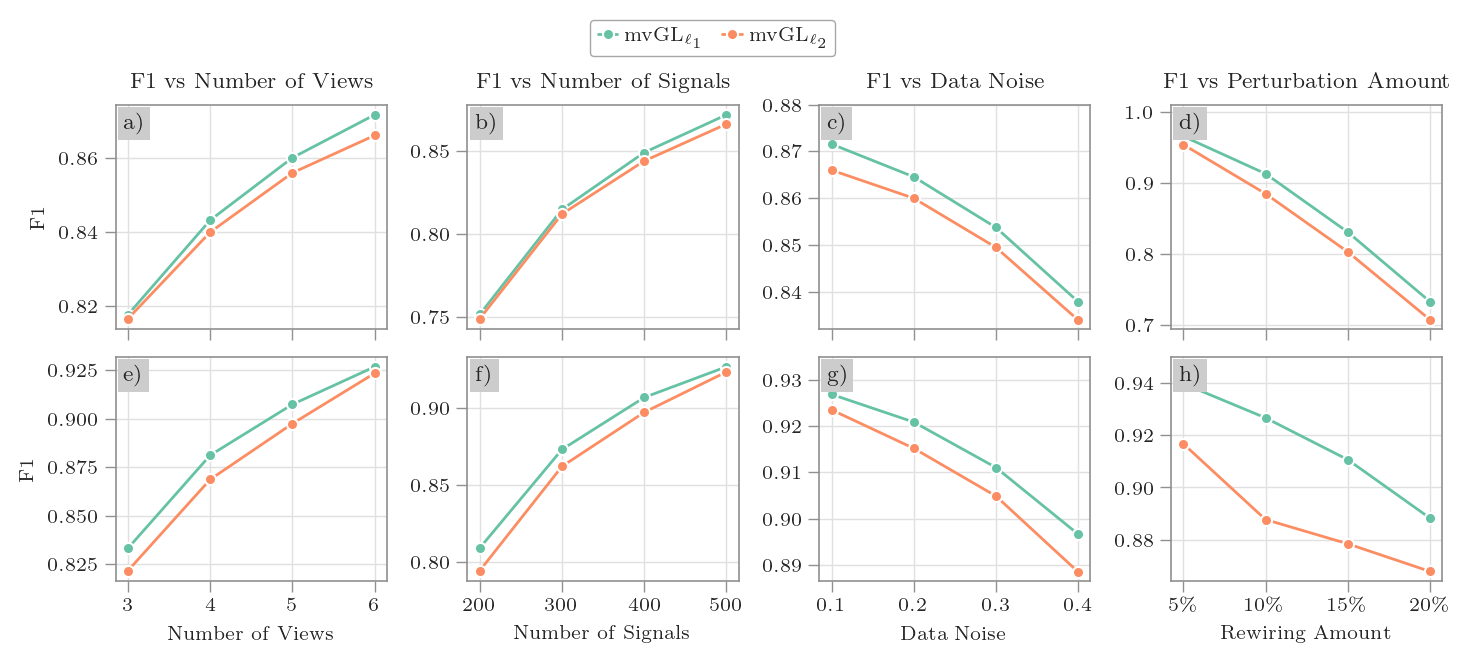

In [61]:
fig = plt.figure(figsize=(7.2, 3.2), constrained_layout=True)
gs = fig.add_gridspec(3, 4, height_ratios = (1, 8, 8))

hue_order = ["mvgl-l1", "mvgl-l2"]

######

ax = fig.add_subplot(gs[1, 0])
sns.lineplot(view_perf["exp1"], x="Varying", y=metric, hue="Method", ax=ax, 
            legend=True, marker="o", markersize=4, linewidth=1, hue_order=hue_order,
            errorbar=None)

handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)
ax.set_title(r"F1 vs Number of Views")
ax.set_xlabel("")
ax.set_ylabel("F1")
ax.set_xticklabels([])

ax.annotate(r"a)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, -0.35), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

#####

ax = fig.add_subplot(gs[1, 1])
sns.lineplot(view_perf["exp2"], x="Varying", y=metric, hue="Method", ax=ax, 
            legend=False, marker="o", markersize=4, linewidth=1, hue_order=hue_order,
            errorbar=None)

ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)
ax.set_title(r"F1 vs Number of Signals")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])

ax.annotate(r"b)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, -0.35), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

#####

ax = fig.add_subplot(gs[1, 2])
sns.lineplot(view_perf["exp3"], x="Varying", y=metric, hue="Method", ax=ax, 
            legend=False, marker="o", markersize=4, linewidth=1, hue_order=hue_order,
            errorbar=None)

ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)
ax.set_title(r"F1 vs Data Noise")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
start, end = ax.get_ylim() 
ax.set_ylim([start, 0.88])

ax.annotate(r"c)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, -0.35), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

#####

ax = fig.add_subplot(gs[1, 3])
sns.lineplot(view_perf["exp4"], x="Varying", y="LearnedSimilarity", hue="Method", ax=ax, 
            legend=False, marker="o", markersize=4, linewidth=1, hue_order=hue_order,
            errorbar=None)

ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)
ax.set_title(r"F1 vs Perturbation Amount")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
start, end = ax.get_ylim()
ax.set_ylim([start, 1.01])

ax.annotate(r"d)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, -0.35), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

##### 

ax = fig.add_subplot(gs[2, 0])
sns.lineplot(consensus_perf["exp1"], x="Varying", y=metric, hue="Method", ax=ax, 
            legend=True, marker="o", markersize=4, linewidth=1, hue_order=hue_order,
            errorbar=None)

handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)
ax.set_xlabel("Number of Views")
ax.set_ylabel("F1")

ax.annotate(r"e)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, -0.35), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))


#####

ax = fig.add_subplot(gs[2, 1])
sns.lineplot(consensus_perf["exp2"], x="Varying", y=metric, hue="Method", ax=ax, 
            legend=False, marker="o", markersize=4, linewidth=1, hue_order=hue_order,
            errorbar=None)

ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)
ax.set_xlabel("Number of Signals")
ax.set_ylabel("")

ax.annotate(r"f)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, -0.35), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

#####

ax = fig.add_subplot(gs[2, 2])
sns.lineplot(consensus_perf["exp3"], x="Varying", y=metric, hue="Method", ax=ax, 
            legend=False, marker="o", markersize=4, linewidth=1, hue_order=hue_order,
            errorbar=None)

ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)
ax.set_xlabel("Data Noise")
ax.set_ylabel("")
start, end = ax.get_ylim()
ax.set_ylim([start, 0.935])

ax.annotate(r"g)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, -0.35), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

#####

ax = fig.add_subplot(gs[2, 3])
sns.lineplot(consensus_perf["exp4"], x="Varying", y=metric, hue="Method", ax=ax, 
            legend=False, marker="o", markersize=4, linewidth=1, hue_order=hue_order,
            errorbar=None)

ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)
ax.set_xlabel("Rewiring Amount")
ax.set_ylabel("")
ax.set_xticks(np.arange(0.05, 0.21, 0.05), labels=[f"{i}\%" for i in range(5, 21, 5)])
start, end = ax.get_ylim()
ax.set_ylim([start, 0.95])


ax.annotate(r"h)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, -0.35), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

#####

ax = fig.add_subplot(gs[0, :])
labels = [r"$\textrm{mvGL}_{\ell_1}$", r"$\textrm{mvGL}_{\ell_2}$"]
legend = ax.legend(handles, labels, ncols=5, loc="center", bbox_to_anchor=[0.45, 0.5], 
                   handlelength=1, handletextpad=0.4, columnspacing=1)
ax.set_axis_off()
legend.get_frame().set_linewidth(0.5)
legend.get_frame().set_edgecolor("#909090")

#####

fig.get_layout_engine().set(w_pad=0.025)

fig_fname = Path(mvgl.ROOT_DIR, "reports", "figures", "parameter_sensitivity_response.pdf")
fig.savefig(fig_fname, pad_inches=0.05)

In [10]:
view_perf["exp4"]

,Run,Method,F1,AUPRC,Accuracy,NMI,Precision,Recall,Graph,Density,Similarity,LearnedDensity,LearnedSimilarity,RunTime,Varying,index
198,0,mvgl-l1,0.901551,0.916779,0.978653,0.732947,0.874144,0.930748,view,0.12,0.98,0.111818,0.969534,0.217273,0.05,13998
136,0,mvgl-l1,0.855651,0.810619,0.971178,0.650764,0.901615,0.814187,view,0.10,0.86,0.094747,0.853069,0.283220,0.10,71436
140,0,mvgl-l1,0.838337,0.784032,0.967677,0.619027,0.881566,0.799285,view,0.10,0.90,0.095084,0.893711,0.280327,0.15,128940
118,0,mvgl-l1,0.799246,0.748811,0.960202,0.555211,0.847223,0.756662,view,0.10,0.68,0.093569,0.670104,0.202031,0.20,186418
144,0,mvgl-l2,0.896471,0.857934,0.979293,0.731095,0.943677,0.853801,view,0.10,0.94,0.095017,0.931818,0.327620,0.05,243944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56480,49,mvgl-l2,0.810635,0.777808,0.962020,0.569418,0.831461,0.791083,view,0.10,0.80,0.097744,0.794003,0.327489,0.20,472780
3387,49,svgl,0.674686,0.625839,0.935253,0.377219,0.698301,0.653331,view,0.10,NaN,0.096263,0.415702,0.009865,0.05,3387
3387,49,svgl,0.669426,0.618058,0.933973,0.370084,0.690328,0.650185,view,0.10,NaN,0.096902,0.341182,0.007963,0.10,6837
3387,49,svgl,0.670062,0.616182,0.935219,0.373011,0.702475,0.640652,view,0.10,NaN,0.093670,0.295291,0.008671,0.15,10287


### Performance across graph models

In [76]:
metric = "F1"
graph_model = "er"
fltr = "gaussian"
methods = ["svgl", "mvgl-l1", "mvgl-l2"]

view_perf = {}
consensus_perf = {}
for graph_model in ["er", "ba", "rgg"]:
    exp_file = lambda v: f"revision-exp6-{graph_model}-{fltr}"
    performances = read_perfs(exp_file, methods, n_views)
    view_perf[graph_model], consensus_perf[graph_model] = get_best_perf(performances, metric)

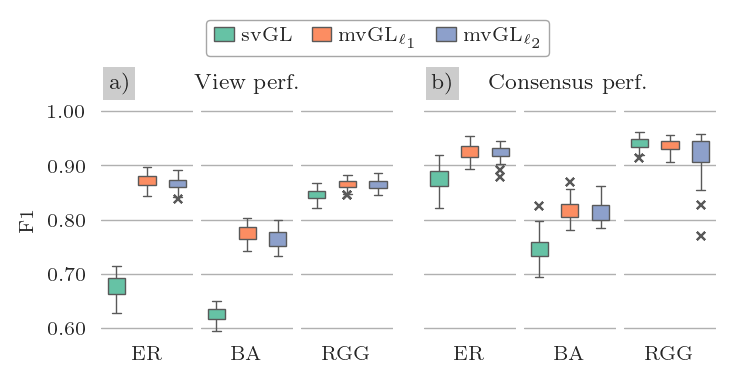

In [95]:
fig = plt.figure(figsize=(3.5, 1.8), constrained_layout=True)
gs = fig.add_gridspec(2, 7, height_ratios = (1, 8), 
                      width_ratios = (1, 1, 1, 0.2, 1, 1, 1))

lw = 0.5
fs = 3

hue_order = ["svgl", "mvgl-l1", "mvgl-l2"]

######

ax = fig.add_subplot(gs[1, 0])
sns.boxplot(view_perf["er"], x="Method", y="F1", hue="Method", ax=ax, 
            legend=True, gap=0.3, linewidth=lw, saturation=1,
            fliersize=fs, flierprops={"markeredgewidth": 0.7, "marker": "x"},
            medianprops={"linewidth": 0}, order=hue_order, hue_order=hue_order)

ax.set_xticklabels([])
ax.tick_params(axis="x", length=0)
ax.tick_params(axis="y", pad=0)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xlabel("ER", labelpad=1)
ax.set_ylabel(r"F1")
ax.grid(axis="y", visible=True)
handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
ax.set_ylim([0.59, 1.01])
for side in ["top", "right", "bottom", "left"]:
    ax.spines[side].set_visible(False)

ax.annotate(r"a)", xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.35, 1.5), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

######

ax = fig.add_subplot(gs[1, 1])
sns.boxplot(view_perf["ba"], x="Method", y="F1", hue="Method", ax=ax, 
            gap=0.3, linewidth=lw, saturation=1, fliersize=fs, 
            flierprops={"markeredgewidth": 0.7, "marker": "x"},
            medianprops={"linewidth": 0}, order=hue_order, hue_order=hue_order)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis="x", length=0)
ax.set_xlabel("BA", labelpad=1)
ax.set_ylabel("")
ax.grid(axis="y", visible=True)
ax.set_ylim([0.59, 1.01])
ax.set_title("View perf.")
for side in ["top", "right", "bottom", "left"]:
    ax.spines[side].set_visible(False)

######

ax = fig.add_subplot(gs[1, 2])
sns.boxplot(view_perf["rgg"], x="Method", y="F1", hue="Method", ax=ax, 
            gap=0.3, linewidth=lw, saturation=1, fliersize=fs, 
            flierprops={"markeredgewidth": 0.7, "marker": "x"},
            medianprops={"linewidth": 0}, order=hue_order, hue_order=hue_order)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis="x", length=0)
ax.set_xlabel("RGG", labelpad=1)
ax.set_ylabel("")
ax.grid(axis="y", visible=True)
ax.set_ylim([0.59, 1.01])
for side in ["top", "right", "bottom", "left"]:
    ax.spines[side].set_visible(False)

#####

ax = fig.add_subplot(gs[1, 4])
sns.boxplot(consensus_perf["er"], x="Method", y="F1", hue="Method", ax=ax, 
            legend=True, gap=0.3, linewidth=lw, saturation=1,
            fliersize=fs, flierprops={"markeredgewidth": 0.7, "marker": "x"},
            medianprops={"linewidth": 0}, order=hue_order, hue_order=hue_order)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis="x", length=0)
ax.tick_params(axis="y", pad=0)
ax.set_xlabel("ER", labelpad=1)
ax.set_ylabel("")
ax.grid(axis="y", visible=True)
handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
ax.set_ylim([0.59, 1.01])
for side in ["top", "right", "bottom", "left"]:
    ax.spines[side].set_visible(False)

ax.annotate(r"b)", xy=(0, 1), xycoords='axes fraction',
            xytext=(0.35, 1.5), textcoords='offset fontsize',
            fontsize=8, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

######

ax = fig.add_subplot(gs[1, 5])
sns.boxplot(consensus_perf["ba"], x="Method", y="F1", hue="Method", ax=ax, 
            gap=0.3, linewidth=lw, saturation=1, fliersize=fs, 
            flierprops={"markeredgewidth": 0.7, "marker": "x"},
            medianprops={"linewidth": 0}, order=hue_order, hue_order=hue_order)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis="x", length=0)
ax.set_xlabel("BA", labelpad=1)
ax.set_ylabel("")
ax.grid(axis="y", visible=True)
ax.set_ylim([0.59, 1.01])
ax.set_title("Consensus perf.")
for side in ["top", "right", "bottom", "left"]:
    ax.spines[side].set_visible(False)

######

ax = fig.add_subplot(gs[1, 6])
sns.boxplot(consensus_perf["rgg"], x="Method", y="F1", hue="Method", ax=ax, 
            gap=0.3, linewidth=lw, saturation=1, fliersize=fs, 
            flierprops={"markeredgewidth": 0.7, "marker": "x"},
            medianprops={"linewidth": 0}, order=hue_order, hue_order=hue_order)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis="x", length=0)
ax.set_xlabel("RGG", labelpad=1)
ax.set_ylabel("")
ax.grid(axis="y", visible=True)
ax.set_ylim([0.59, 1.01])
for side in ["top", "right", "bottom", "left"]:
    ax.spines[side].set_visible(False)

#####

ax = fig.add_subplot(gs[0, :])
labels = [r"$\textrm{svGL}$",
          r"$\textrm{mvGL}_{\ell_1}$", r"$\textrm{mvGL}_{\ell_2}$"]
legend = ax.legend(handles, labels, ncols=5, loc="center", bbox_to_anchor=[0.45, 0.5], 
                   handlelength=1, handletextpad=0.4, columnspacing=1)
ax.set_axis_off()
legend.get_frame().set_linewidth(0.5)
legend.get_frame().set_edgecolor("#909090")

#####

fig.get_layout_engine().set(w_pad=0.01)

fig_fname = Path(mvgl.ROOT_DIR, "reports", "figures", "graph_model_effect.pdf")
fig.savefig(fig_fname, pad_inches=0.05)

### Hyperparameter Sensitivity

In [84]:
metric = "F1"
graph_model = "er"
methods = ["mvgl-l1"]

exp_file = lambda v: f"revision-exp7-{graph_model}-{v:.2f}-{fltr}"
performances = read_perfs(exp_file, methods, [0.10])
performances["Similarity"] = performances["Similarity"].ffill()

view_perf = performances.loc[performances["Graph"] == "view", 
                             ["Run", "F1", "Density", "Similarity"]]
view_perf = view_perf.groupby(["Density", "Similarity"], as_index=False)["F1"].mean()
view_perf = view_perf.pivot(index="Density", columns="Similarity", values="F1")

consensus_perf = performances.loc[performances["Graph"] == "consensus", 
                             ["Run", "F1", "Density", "Similarity"]]
consensus_perf = consensus_perf.groupby(["Density", "Similarity"], as_index=False)["F1"].mean()
consensus_perf = consensus_perf.pivot(index="Density", columns="Similarity", values="F1")

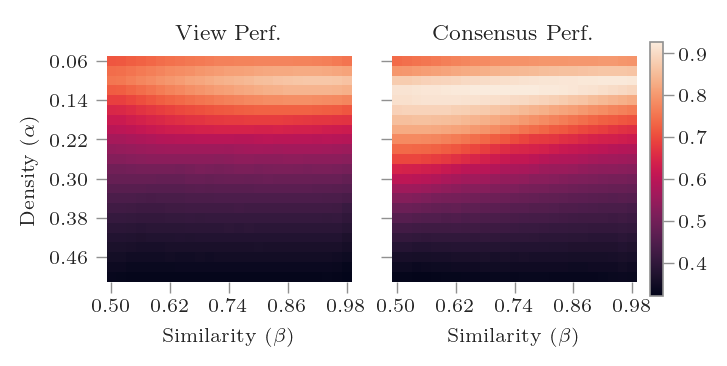

In [185]:
fig = plt.figure(figsize=(3.5, 1.7), constrained_layout=True)
gs = fig.add_gridspec(1, 3, width_ratios=(10, 10, 1))

vmin = min(view_perf.min().min(), consensus_perf.min().min())
vmax = max(view_perf.max().max(), consensus_perf.max().max())

#####

ax = fig.add_subplot(gs[0, 0])
sns.heatmap(view_perf, ax=ax, square=True, cbar=False, vmin=vmin, vmax=vmax, 
            rasterized=True)

ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)

ax.set_title("View Perf.")
yticks = ax.get_yticks()
yticks = [yticks[i] for i in range(0, len(yticks), 2)]
ax.set_yticks(yticks, 
              [f"{i:.2f}" for i in np.linspace(0.06, 0.46, len(yticks), endpoint=True)])
ax.set_ylabel(r"Density ($\alpha$)")

xticks = ax.get_xticks()
xticks = [xticks[i] for i in range(0, len(xticks), 2)]
ax.set_xticks(xticks, 
              [f"{i:.2f}" for i in np.linspace(0.5, 0.98, len(xticks), endpoint=True)])
ax.set_xlabel(r"Similarity ($\beta$)")

#####

ax = fig.add_subplot(gs[0, 1])
sns.heatmap(consensus_perf, ax=ax, square=True, cbar=False, vmin=vmin, vmax=vmax, 
            rasterized=True)

ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)

ax.set_title("Consensus Perf.")
yticks = ax.get_yticks()
yticks = [yticks[i] for i in range(0, len(yticks), 2)]
ax.set_yticks(yticks, [])
ax.set_ylabel("")

xticks = ax.get_xticks()
xticks = [xticks[i] for i in range(0, len(xticks), 2)]
ax.set_xticks(xticks, 
              [f"{i:.2f}" for i in np.linspace(0.5, 0.98, len(xticks), endpoint=True)])
ax.set_xlabel(r"Similarity ($\beta$)")

#####

ax = fig.add_subplot(gs[0, 2])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = sns.color_palette("rocket", as_cmap=True)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, 
                    fraction=0.8, aspect=20, pad=-1.5, shrink=0.85)
cbar.ax.tick_params(axis="y", reset=True, length=4, width=0.5, color="#909090", 
               left=False, right=True, labelleft=False, labelright=True, pad=2)
ax.set_axis_off()
cbar.ax.set_yticks(np.arange(0.4, 0.91, 0.1))

#####

fig.get_layout_engine().set(w_pad=0.025)

fig_fname = Path(mvgl.ROOT_DIR, "reports", "figures", "hyperparam-sensitivity.pdf")
fig.savefig(fig_fname, pad_inches=0.05)

### Adjacency Matrix

In [57]:
consensus_kws = dict(graph_generator="er", p=0.2)
view_kws = dict(perturbation=0.1)
signal_kws = dict(filter="gaussian")

# Generate simulated data
Gc, Gv, Xv = mvgl.gen_simulated_data(20, 2, 500, "smooth", 0.1, 
                                     consensus_kws=consensus_kws,
                                     view_kws=view_kws, signal_kws=signal_kws)

# Data pre-processing
scaler = StandardScaler()
for i in range(len(Xv)):
    Xv[i] = scaler.fit_transform(Xv[i].T).T

# Learn the graph
wv_hat, wc_hat, params, rt = mvgl.learn_multiview_graph(
    Xv, 0.1, 0.1, "l1", view_density=0.2, similarity=0.8
)


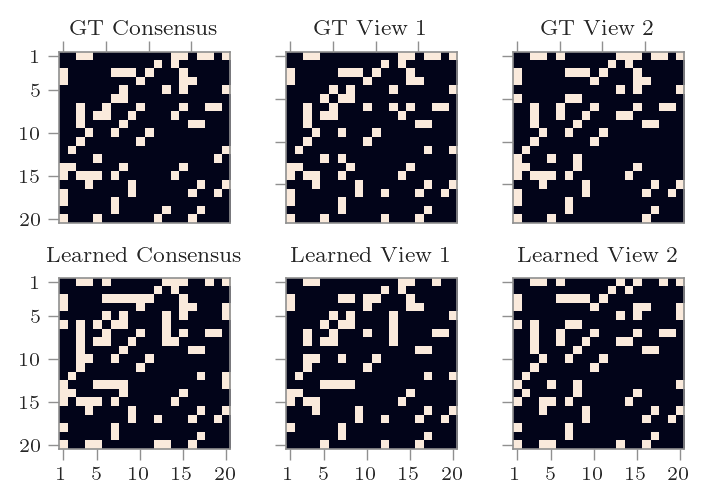

In [59]:
Wv_gt = []
Wv_hat = []
for i in range(len(wv_hat)):
    Wv_gt.append(nx.adjacency_matrix(Gv[i]).toarray())
    Wv_hat.append(np.zeros_like(Wv_gt[i]))
    Wv_hat[i][np.triu_indices_from(Wv_hat[i], k=1)] = np.squeeze((wv_hat[i]>0).astype(float))
    Wv_hat[i] = Wv_hat[i] + Wv_hat[i].T

Wc_gt = nx.adjacency_matrix(Gc).toarray()
Wc_hat = np.zeros_like(Wc_gt)
Wc_hat[np.triu_indices_from(Wc_hat, k=1)] = np.squeeze((wc_hat>0).astype(float))
Wc_hat = Wc_hat + Wc_hat.T

#####

fig = plt.figure(figsize=(3.5, 2.4), constrained_layout=True)
gs = fig.add_gridspec(2, 3)

#####

ax = fig.add_subplot(gs[0, 0])
ax.matshow(Wc_gt)
ax.grid(False)
ax.set_yticks(ticks=[0, 4, 9, 14, 19], labels=[1, 5, 10, 15, 20])
ax.set_yticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
ax.tick_params(axis="y", length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", length=4, width=0.5, color="#909090", 
               bottom=False, top=True, pad=2)
ax.set_xticklabels([])
ax.set_title("GT Consensus")

#####

ax = fig.add_subplot(gs[0, 1])
ax.matshow(Wv_gt[0])
ax.grid(False)
ax.tick_params(axis="y", length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", length=4, width=0.5, color="#909090", 
               bottom=False, top=True, pad=2)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title("GT View 1")

#####

ax = fig.add_subplot(gs[0, 2])
ax.matshow(Wv_gt[1])
ax.grid(False)
ax.tick_params(axis="y", length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", length=4, width=0.5, color="#909090", 
               bottom=False, top=True, pad=2)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title("GT View 2")

#####

ax = fig.add_subplot(gs[1, 0])
ax.matshow(Wc_hat)
ax.set_yticks(ticks=[0, 4, 9, 14, 19], labels=[1, 5, 10, 15, 20])
ax.set_xticks(ticks=[0, 4, 9, 14, 19], labels=[1, 5, 10, 15, 20])
ax.set_yticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
ax.tick_params(axis="y", length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)
ax.grid(False)
ax.set_title("Learned Consensus")

#####

ax = fig.add_subplot(gs[1, 1])
ax.matshow(Wv_hat[0])
ax.set_yticks(ticks=[0, 4, 9, 14, 19], labels=[1, 5, 10, 15, 20])
ax.set_xticks(ticks=[0, 4, 9, 14, 19], labels=[1, 5, 10, 15, 20])
ax.set_yticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
ax.tick_params(axis="y", length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)
ax.set_yticklabels([])
ax.grid(False)
ax.set_title("Learned View 1")

#####

ax = fig.add_subplot(gs[1, 2])
ax.matshow(Wv_hat[1])
ax.set_yticks(ticks=[0, 4, 9, 14, 19], labels=[1, 5, 10, 15, 20])
ax.set_xticks(ticks=[0, 4, 9, 14, 19], labels=[1, 5, 10, 15, 20])
ax.set_yticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
ax.tick_params(axis="y", length=4, width=0.5, color="#909090", 
               left=True, right=False, pad=2)
ax.tick_params(axis="x", reset=True, length=4, width=0.5, color="#909090", 
               bottom=True, top=False, pad=2)
ax.set_yticklabels([])
ax.grid(False)
ax.set_title("Learned View 2")

#####

# fig.get_layout_engine().set(w_pad=0.05)

fig_fname = Path(mvgl.ROOT_DIR, "reports", "figures", "adjacencies.pdf")
fig.savefig(fig_fname, pad_inches=0.05)

### To Clean

In [12]:
n_edges_to_add = 100
n_edges_to_remove = 0
metric = "F1"
graph_model = "er"

methods = ["mvgl-l1", "mvgl-l2", "mvgl-pw-l1", "mvgl-pw-l2"]

performances = []
for method in methods:
    exp_file = f"revision-exp5-{graph_model}-gaussian"
    save_path = Path(
        mvgl.ROOT_DIR, "data", "simulations", "outputs",
        exp_file, 
    )
    save_file = Path(save_path, f"{method}.csv")

    perf = pd.read_csv(save_file, index_col=0)
    performances.append(perf)

performances = pd.concat(performances)

performances["index"] = np.arange(len(performances))
grouped = performances.groupby(["Run", "Method"], as_index=False)

view_indices = []
consensus_indices = []
for i, group in grouped:
    view_perf = group[group["Graph"] == "view"]
    best_indx = np.argmax(view_perf[metric])
    view_indices.append(view_perf.iloc[best_indx]["index"])
    if i[1] in ["mvgl-l1", "mvgl-l2"]:
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 1) 
    elif i[1] == "mvgl-pw-l2":
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 1) # Mean
    elif i[1] == "mvgl-pw-l1":
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 2) # Median
    else:
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 2)

view_perf = performances.iloc[view_indices, :]
consensus_perf = performances.iloc[consensus_indices, :]

<Axes: xlabel='Varying', ylabel='F1'>

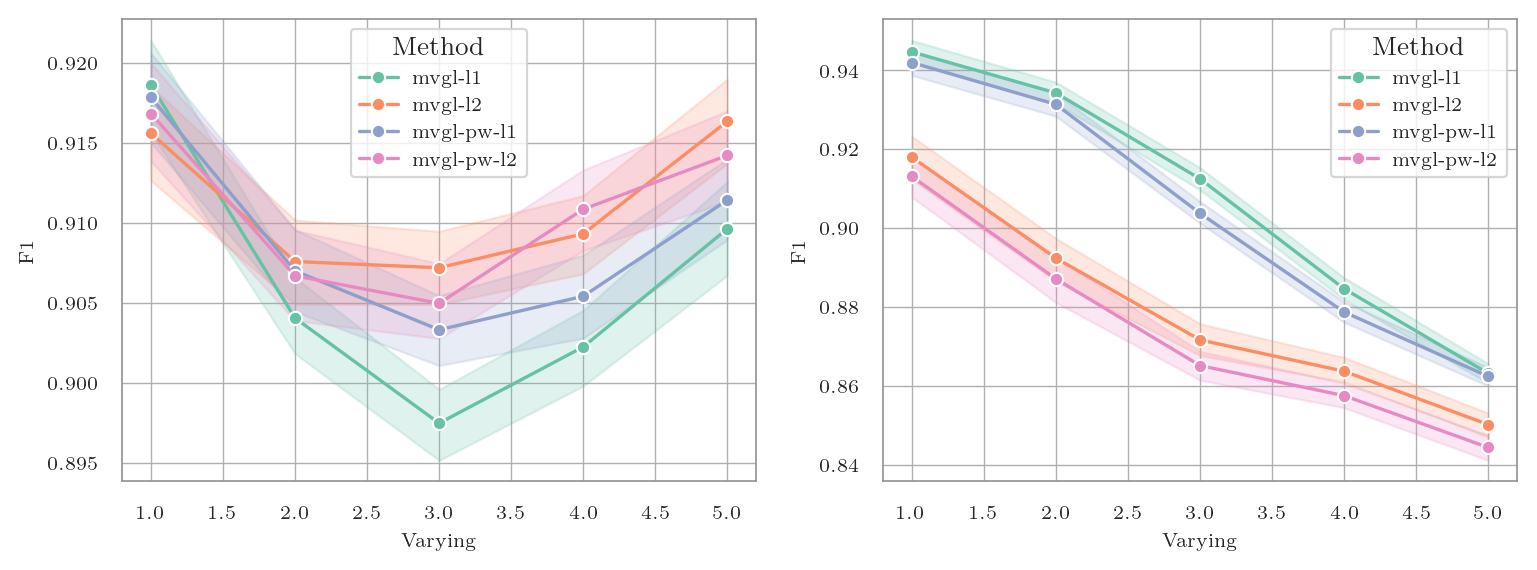

In [37]:
n_edges_to_add = 100
n_edges_to_remove = 0
metric = "F1"
graph_model = "er"

methods = ["mvgl-l1", "mvgl-l2", "mvgl-pw-l1", "mvgl-pw-l2"]

performances = []
for method in methods:
    for n_views_to_change in range(1, 6):
        exp_file = (f"revision-exp1-{graph_model}-{n_edges_to_add}-"
                    f"{n_edges_to_remove}-{n_views_to_change}")
        save_path = Path(
            mvgl.ROOT_DIR, "data", "simulations", "outputs",
            exp_file, 
        )
        save_file = Path(save_path, f"{method}.csv")

        perf = pd.read_csv(save_file, index_col=0)
        perf["Varying"] = n_views_to_change
        performances.append(perf)

performances = pd.concat(performances)

performances["index"] = np.arange(len(performances))
grouped = performances.groupby(["Run", "Method", "Varying"], as_index=False)

view_indices = []
consensus_indices = []
for i, group in grouped:
    view_perf = group[group["Graph"] == "view"]
    best_indx = np.argmax(view_perf[metric])
    view_indices.append(view_perf.iloc[best_indx]["index"])
    if i[1] in ["mvgl-l1", "mvgl-l2"]:
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 1) 
    elif i[1] == "mvgl-pw-l2":
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 1) # Mean
    elif i[1] == "mvgl-pw-l1":
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 2) # Median
    else:
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 2)

view_perf = performances.iloc[view_indices, :]
consensus_perf = performances.iloc[consensus_indices, :]

fig, axs = plt.subplots(ncols=2, figsize=(9, 3))

ax = axs[0]
sns.lineplot(view_perf, x="Varying", y=metric, hue="Method", marker="o", 
             ax = ax)

# ax.set_ylim(0.74, 1.01)

ax = axs[1]
sns.lineplot(consensus_perf, x="Varying", y=metric, hue="Method", marker="o", 
             ax = ax)
# ax.set_ylim(0.74, 0.96)


<Axes: xlabel='Varying', ylabel='F1'>

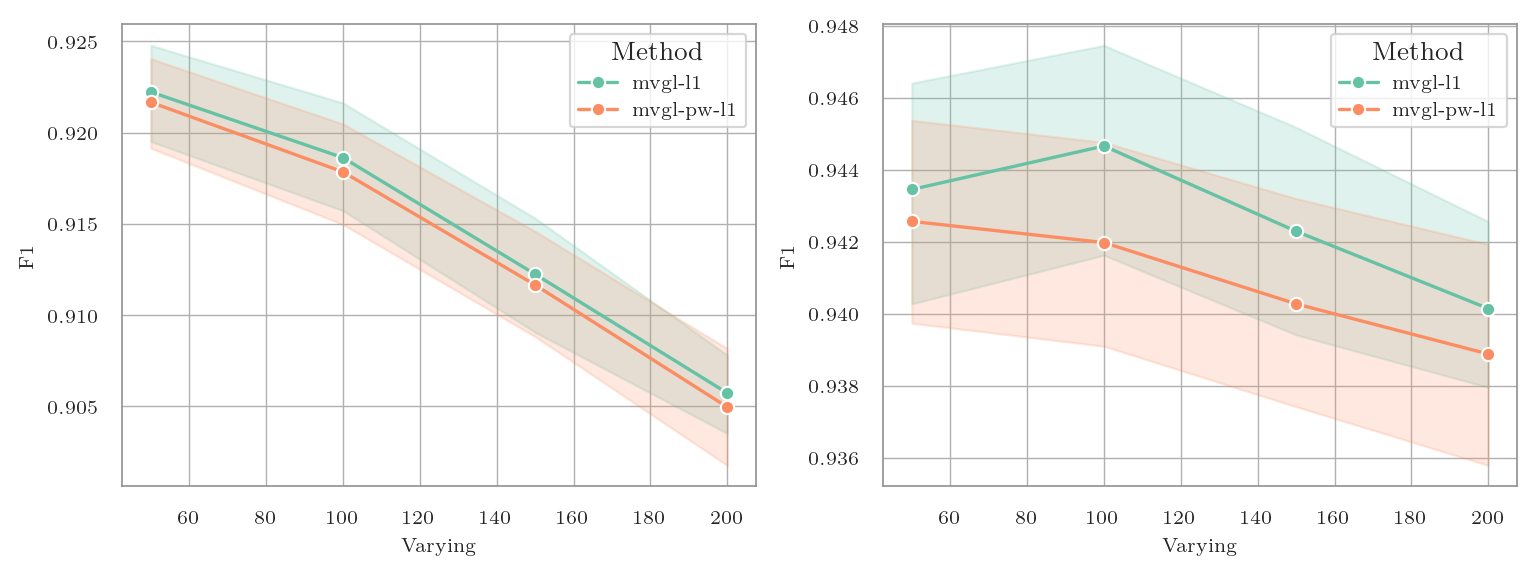

In [36]:
n_edges_to_add = 100
n_edges_to_remove = 0
metric = "F1"
graph_model = "er"

methods = ["mvgl-l1", "mvgl-pw-l1"]

performances = []
for method in methods:
    for n_edges_to_add in range(50, 201, 50):
        exp_file = (f"revision-exp1-{graph_model}-{n_edges_to_add}-"
                    f"{n_edges_to_remove}-{1}")
        save_path = Path(
            mvgl.ROOT_DIR, "data", "simulations", "outputs",
            exp_file, 
        )
        save_file = Path(save_path, f"{method}.csv")

        perf = pd.read_csv(save_file, index_col=0)
        perf["Varying"] = n_edges_to_add
        performances.append(perf)

performances = pd.concat(performances)

performances["index"] = np.arange(len(performances))
grouped = performances.groupby(["Run", "Method", "Varying"], as_index=False)

view_indices = []
consensus_indices = []
for i, group in grouped:
    view_perf = group[group["Graph"] == "view"]
    best_indx = np.argmax(view_perf[metric])
    view_indices.append(view_perf.iloc[best_indx]["index"])
    if i[1] in ["mvgl-l1", "mvgl-l2"]:
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 1) 
    elif i[1] == "mvgl-pw-l2":
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 1) # Mean
    elif i[1] == "mvgl-pw-l1":
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 2) # Median
    else:
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 2)

view_perf = performances.iloc[view_indices, :]
consensus_perf = performances.iloc[consensus_indices, :]

fig, axs = plt.subplots(ncols=2, figsize=(9, 3))

ax = axs[0]
sns.lineplot(view_perf, x="Varying", y=metric, hue="Method", marker="o", 
             ax = ax)

# ax.set_ylim(0.74, 1.01)

ax = axs[1]
sns.lineplot(consensus_perf, x="Varying", y=metric, hue="Method", marker="o", 
             ax = ax)
# ax.set_ylim(0.74, 0.96)


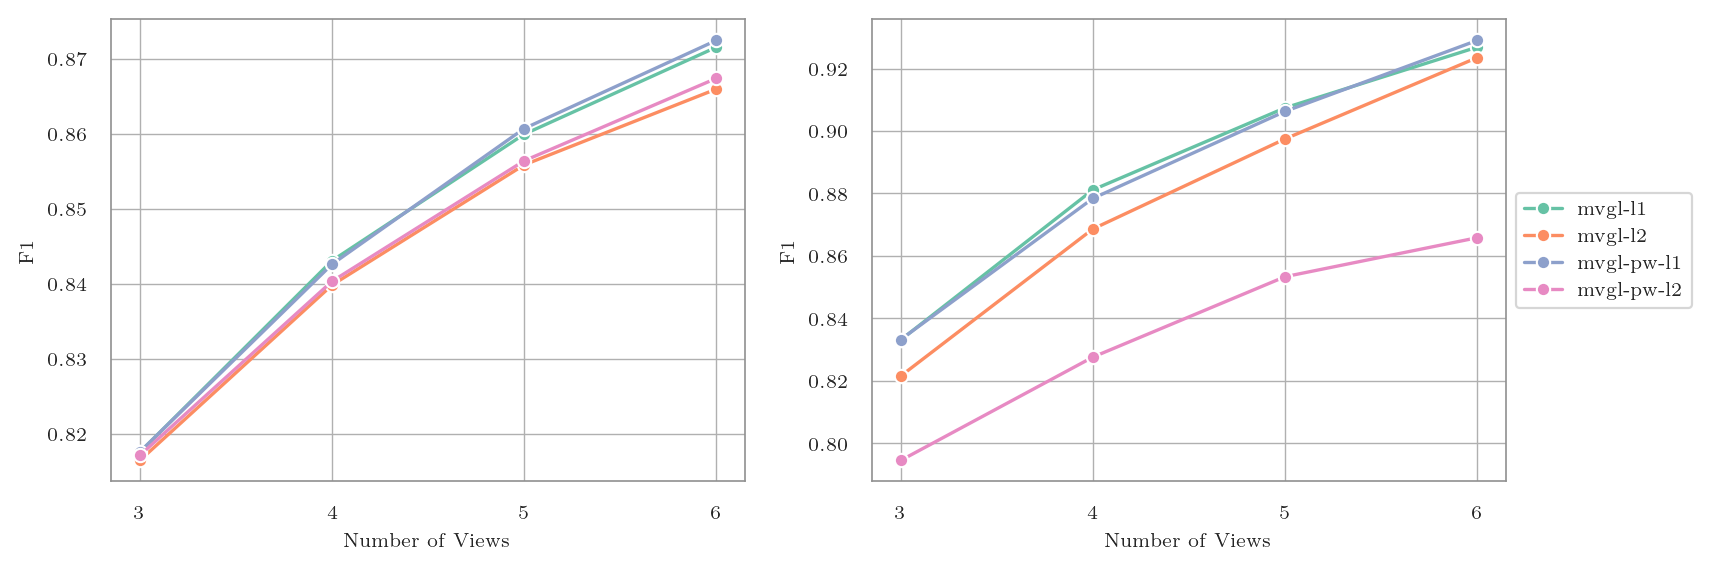

In [39]:
metric = "F1"
graph_model = "er"

methods = ["mvgl-l1", "mvgl-l2", "mvgl-pw-l1", "mvgl-pw-l2"]
fltr = "gaussian"

performances = []
for method in methods:
    for n_views in range(3, 7):
        exp_file = f"exp1-{graph_model}-{n_views}-{fltr}"
        save_path = Path(
            mvgl.ROOT_DIR, "data", "simulations", "outputs",
            exp_file, 
        )
        save_file = Path(save_path, f"{method}.csv")

        perf = pd.read_csv(save_file, index_col=0)
        perf["Varying"] = n_views

        # if method.startswith("jemgl"):
        #     diff = 100
        #     for _, group in perf.groupby("Similarity"):
        #         curr_diff = np.abs(group.iloc[0]["LearnedSimilarity"] - 0.8)
        #         if curr_diff < diff:
        #             perf = group 
        #             diff = curr_diff    
        # else:
        #     perf["Similarity"] = perf["Similarity"].ffill()
        #     perf = perf[perf.Similarity == 0.8]

        performances.append(perf)

performances = pd.concat(performances)

performances["index"] = np.arange(len(performances))
grouped = performances.groupby(["Run", "Method", "Varying"], as_index=False)

view_indices = []
consensus_indices = []
for i, group in grouped:
    view_perf = group[group["Graph"] == "view"]
    best_indx = np.argmax(view_perf[metric])
    view_indices.append(view_perf.iloc[best_indx]["index"])
    if i[1] in ["mvgl-l1", "mvgl-l2"]:
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 1) 
    elif i[1] == "mvgl-pw-l2":
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 1) # Mean
    elif i[1] == "mvgl-pw-l1":
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 2) # Median
    else:
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 2)

view_perf = performances.iloc[view_indices, :]
consensus_perf = performances.iloc[consensus_indices, :]

fig, axs = plt.subplots(ncols=2, figsize=(9, 3))

ax = axs[0]
sns.lineplot(view_perf, x="Varying", y=metric, hue="Method", marker="o", 
             ax = ax, errorbar=None)
ax.legend().remove()
ax.set_xlabel("Number of Views")
ax.set_xticks([3, 4, 5, 6]);

ax = axs[1]
sns.lineplot(consensus_perf, x="Varying", y=metric, hue="Method", marker="o", 
             ax = ax, errorbar=None)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Number of Views")
ax.set_xticks([3, 4, 5, 6]);

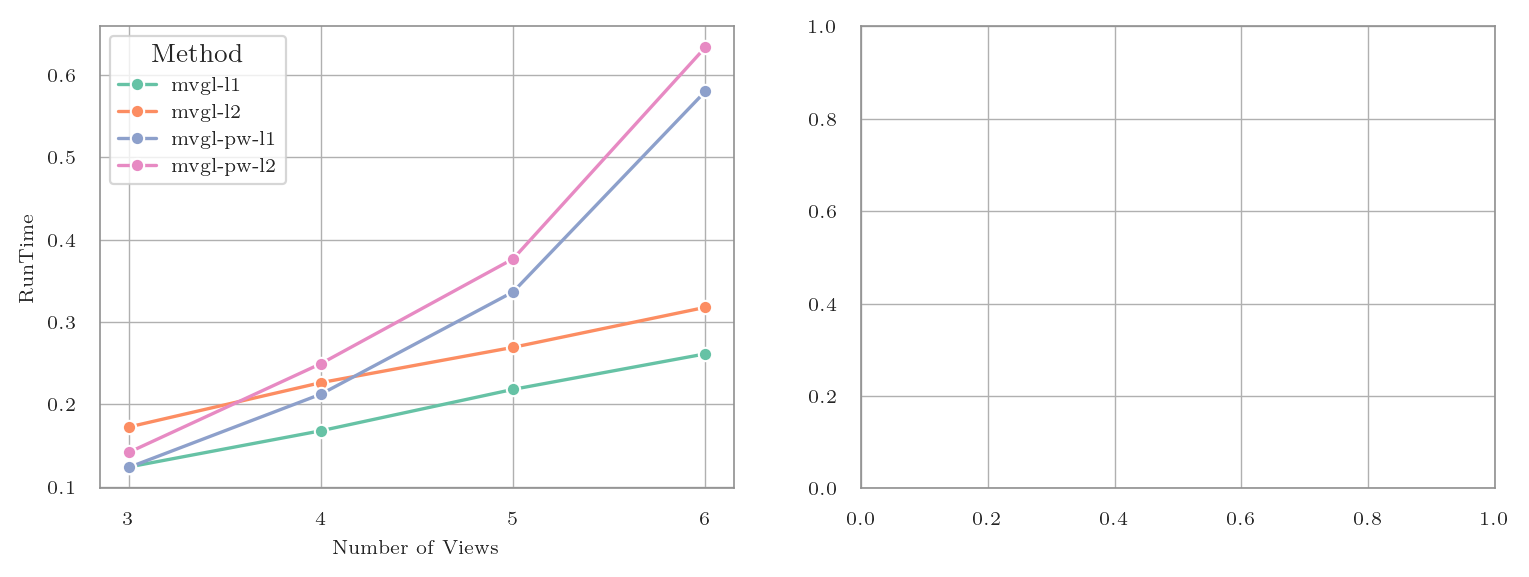

In [41]:
metric = "F1"
graph_model = "er"

methods = ["mvgl-l1", "mvgl-l2", "mvgl-pw-l1", "mvgl-pw-l2"]
fltr = "gaussian"

performances = []
for method in methods:
    for n_views in range(3, 7):
        exp_file = f"exp1-{graph_model}-{n_views}-{fltr}"
        save_path = Path(
            mvgl.ROOT_DIR, "data", "simulations", "outputs",
            exp_file, 
        )
        save_file = Path(save_path, f"{method}.csv")

        perf = pd.read_csv(save_file, index_col=0)
        perf["Varying"] = n_views

        # if method.startswith("jemgl"):
        #     diff = 100
        #     for _, group in perf.groupby("Similarity"):
        #         curr_diff = np.abs(group.iloc[0]["LearnedSimilarity"] - 0.8)
        #         if curr_diff < diff:
        #             perf = group 
        #             diff = curr_diff    
        # else:
        #     perf["Similarity"] = perf["Similarity"].ffill()
        #     perf = perf[perf.Similarity == 0.8]

        performances.append(perf)

performances = pd.concat(performances)

performances["index"] = np.arange(len(performances))
grouped = performances.groupby(["Run", "Method", "Varying"], as_index=False)

view_indices = []
consensus_indices = []
for i, group in grouped:
    view_perf = group[group["Graph"] == "view"]
    best_indx = np.argmax(view_perf[metric])
    view_indices.append(view_perf.iloc[best_indx]["index"])
    if i[1] in ["mvgl-l1", "mvgl-l2"]:
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 1) 
    elif i[1] == "mvgl-pw-l2":
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 1) # Mean
    elif i[1] == "mvgl-pw-l1":
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 2) # Median
    else:
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 2)

view_perf = performances.iloc[view_indices, :]
consensus_perf = performances.iloc[consensus_indices, :]

fig, axs = plt.subplots(ncols=2, figsize=(9, 3))

ax = axs[0]
sns.lineplot(view_perf, x="Varying", y="RunTime", hue="Method", marker="o", 
             ax = ax, errorbar=None)
ax.set_xlabel("Number of Views")
ax.set_xticks([3, 4, 5, 6]);


Text(0.5, 0, 'Number of Signals')

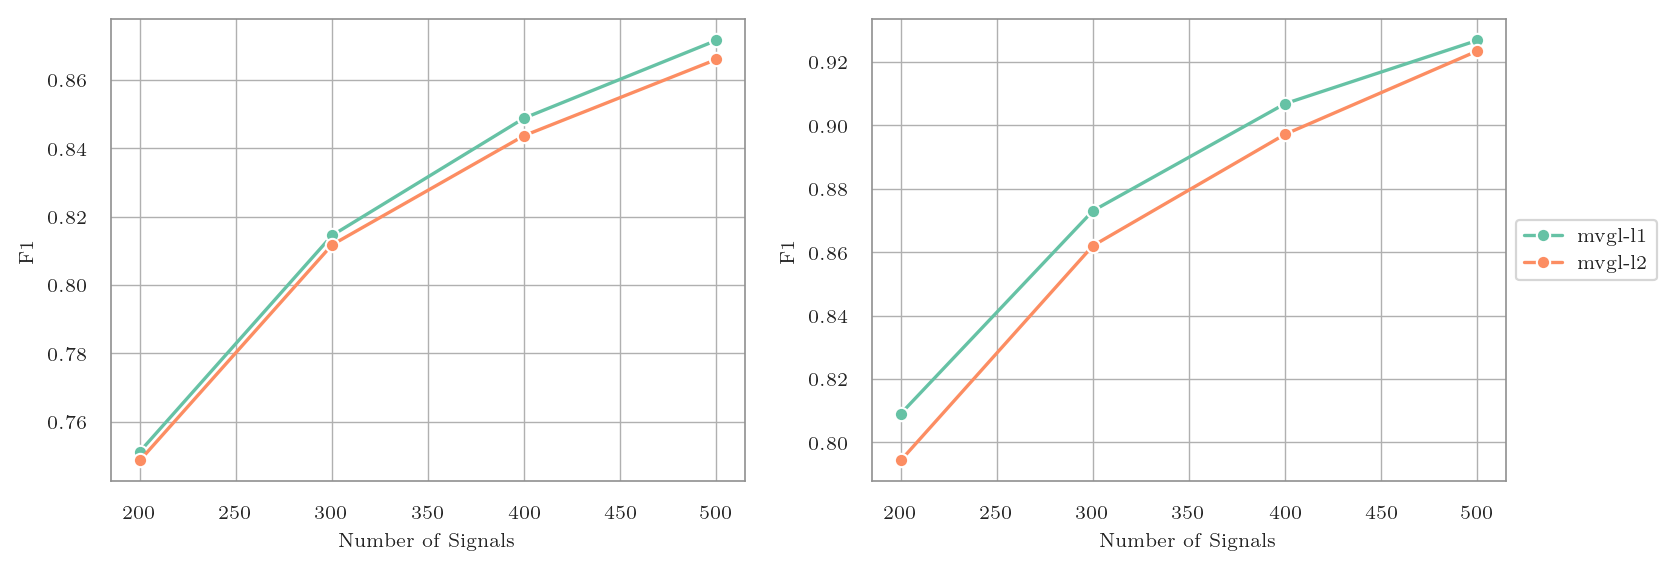

In [28]:
metric = "F1"
graph_model = "er"

methods = ["mvgl-l1", "mvgl-l2"]
fltr = "gaussian"

performances = []
for method in methods:
    for n_signals in range(200, 501, 100):
        exp_file = f"exp2-{graph_model}-{n_signals}-{fltr}"
        save_path = Path(
            mvgl.ROOT_DIR, "data", "simulations", "outputs",
            exp_file, 
        )
        save_file = Path(save_path, f"{method}.csv")

        perf = pd.read_csv(save_file, index_col=0)
        perf["Varying"] = n_signals

        # if method.startswith("jemgl"):
        #     diff = 100
        #     for _, group in perf.groupby("Similarity"):
        #         curr_diff = np.abs(group.iloc[0]["LearnedSimilarity"] - 0.8)
        #         if curr_diff < diff:
        #             perf = group 
        #             diff = curr_diff    
        # else:
        #     perf = perf[perf.Similarity == 0.8]

        performances.append(perf)

performances = pd.concat(performances)

performances["index"] = np.arange(len(performances))
grouped = performances.groupby(["Run", "Method", "Varying"], as_index=False)

view_indices = []
consensus_indices = []
for i, group in grouped:
    view_perf = group[group["Graph"] == "view"]
    best_indx = np.argmax(view_perf[metric])
    view_indices.append(view_perf.iloc[best_indx]["index"])
    if i[1] in ["mvgl-l1", "mvgl-l2"]:
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 1) 
    elif i[1] == "mvgl-pw-l2":
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 1) # Mean
    elif i[1] == "mvgl-pw-l1":
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 2) # Median
    else:
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 2)

view_perf = performances.iloc[view_indices, :]
consensus_perf = performances.iloc[consensus_indices, :]

fig, axs = plt.subplots(ncols=2, figsize=(9, 3))

ax = axs[0]
sns.lineplot(view_perf, x="Varying", y=metric, hue="Method", marker="o", 
             ax = ax, errorbar=None)
ax.legend().remove()
ax.set_xlabel("Number of Signals")
#ax.set_xticks([3, 4, 5, 6]);

ax = axs[1]
sns.lineplot(consensus_perf, x="Varying", y=metric, hue="Method", marker="o", 
             ax = ax, errorbar=None)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Number of Signals")
# ax.set_xticks([3, 4, 5, 6]);

(0.5, 1.01)

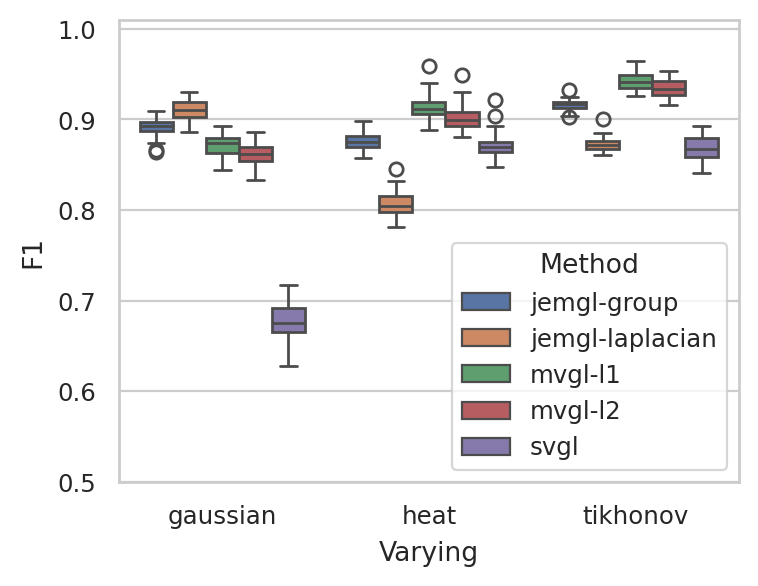

In [29]:
metric = "F1"
graph_model = "er"

methods = ["svgl", "mvgl-l1", "mvgl-l2", "jemgl-group", "jemgl-laplacian"]
filters = ["gaussian", "heat", "tikhonov"]
fltr = "gaussian"

performances = []
for method in methods:
    for fltr in filters:
        exp_file = f"revision-exp2-{graph_model}-{fltr}"
        save_path = Path(
            mvgl.ROOT_DIR, "data", "simulations", "outputs",
            exp_file, 
        )
        save_file = Path(save_path, f"{method}.csv")

        perf = pd.read_csv(save_file, index_col=0)
        perf["Varying"] = fltr

        performances.append(perf)

performances = pd.concat(performances)

performances["index"] = np.arange(len(performances))
grouped = performances.groupby(["Run", "Method", "Varying"], as_index=False)

view_indices = []
consensus_indices = []
for _, group in grouped:
    view_perf = group[group["Graph"] == "view"]
    best_indx = np.argmax(view_perf[metric])
    view_indices.append(view_perf.iloc[best_indx]["index"])
    consensus_indices.append(view_perf.iloc[best_indx]["index"] + 1) 

view_perf = performances.iloc[view_indices, :]
consensus_perf = performances.iloc[consensus_indices, :]

fig, ax = plt.subplots(figsize=(4, 3))

sns.boxplot(view_perf, x="Varying", y=metric, hue="Method", 
             ax=ax)

ax.set_ylim(0.5, 1.01)


# ax = axs[1]
# sns.boxplot(consensus_perf, x="Varying", y=metric, hue="Method",
#              ax = ax)
# ax.set_ylim(0.74, 0.96)

In [20]:
metric = "F1"
graph_model = "er"

methods = ["svgl", "mvgl-l1", "mvgl-l2", "jemgl-laplacian", "jemgl-group", "mvgl-pw-l1", "mvgl-pw-l2"]
fltr = "gaussian"

performances = []
for method in methods:
    for n_views in range(3, 7):
        exp_file = f"exp1-{graph_model}-{n_views}-{fltr}"
        save_path = Path(
            mvgl.ROOT_DIR, "data", "simulations", "outputs",
            exp_file, 
        )
        save_file = Path(save_path, f"{method}.csv")

        perf = pd.read_csv(save_file, index_col=0)
        perf["Varying"] = n_views

        # if method.startswith("jemgl"):
        #     diff = 100
        #     for _, group in perf.groupby("Similarity"):
        #         curr_diff = np.abs(group.iloc[0]["LearnedSimilarity"] - 0.8)
        #         if curr_diff < diff:
        #             perf = group 
        #             diff = curr_diff    
        # else:
        #     perf = perf[perf.Similarity == 0.8]

        performances.append(perf)

performances = pd.concat(performances)

performances["index"] = np.arange(len(performances))
grouped = performances.groupby(["Run", "Method", "Varying"], as_index=False)

view_indices = []
consensus_indices = []
for i, group in grouped:
    view_perf = group[group["Graph"] == "view"]
    best_indx = np.argmax(view_perf[metric])
    view_indices.append(view_perf.iloc[best_indx]["index"])
    if i[1] in ["mvgl-l1", "mvgl-l2"]:
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 1) 
    elif i[1] == "mvgl-pw-l2":
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 1)
    elif i[1] == "mvgl-pw-l1":
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 2)
    else:
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 2)

view_perf = performances.iloc[view_indices, :]
consensus_perf = performances.iloc[consensus_indices, :]

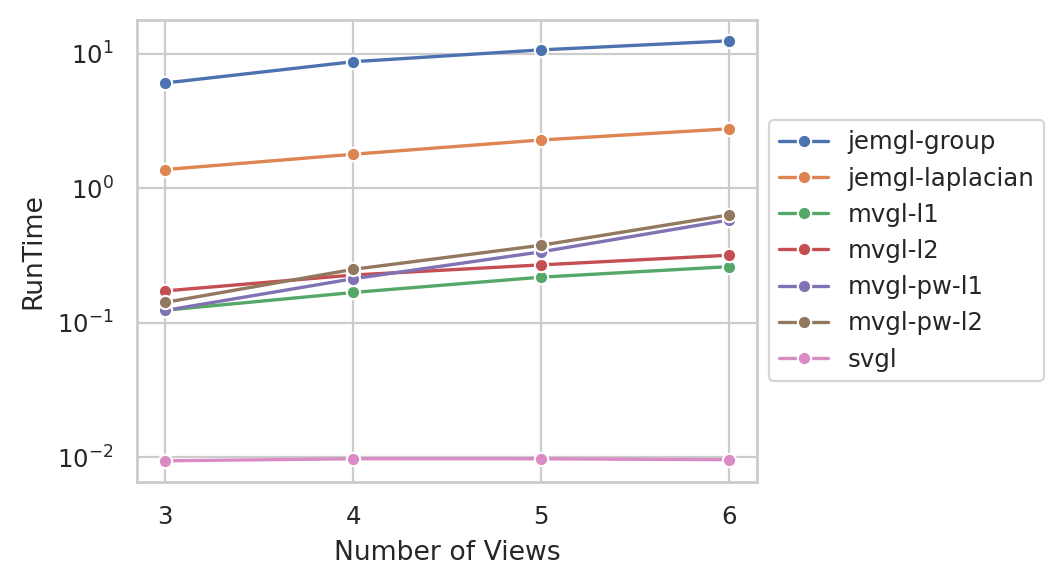

In [21]:
fig, ax = plt.subplots(figsize=(4, 3))

sns.lineplot(view_perf, x="Varying", y="RunTime", hue="Method", marker="o", 
             ax = ax, errorbar=None)
ax.set_yscale("log")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Number of Views")
ax.set_xticks([3, 4, 5, 6]);

Text(0.5, 0, 'Data Noise')

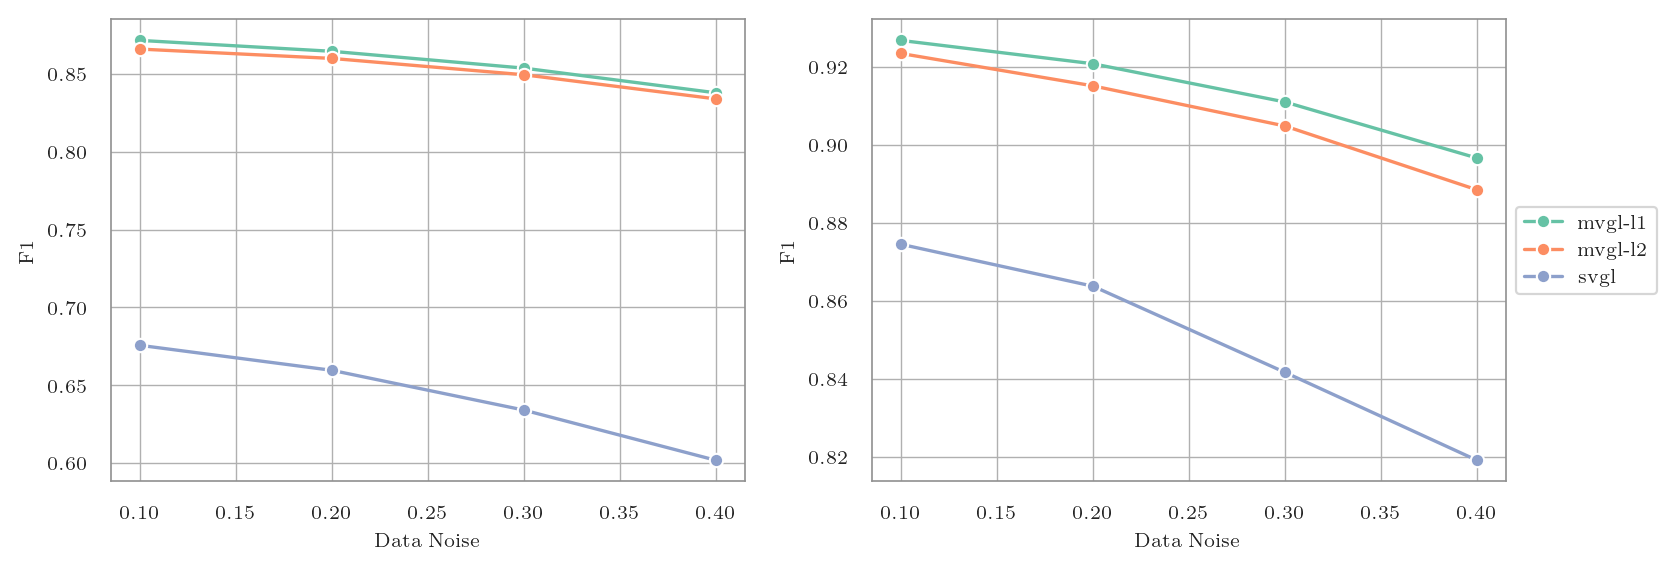

In [33]:
metric = "F1"
graph_model = "er"

methods = ["svgl", "mvgl-l1", "mvgl-l2"]
fltr = "gaussian"

performances = []
for method in methods:
    for n_signals in np.arange(0.1, 0.41, 0.1):
        exp_file = f"exp3-{graph_model}-{n_signals:.2f}-{fltr}"
        save_path = Path(
            mvgl.ROOT_DIR, "data", "simulations", "outputs",
            exp_file, 
        )
        save_file = Path(save_path, f"{method}.csv")

        perf = pd.read_csv(save_file, index_col=0)
        perf["Varying"] = n_signals

        # if method.startswith("jemgl"):
        #     diff = 100
        #     for _, group in perf.groupby("Similarity"):
        #         curr_diff = np.abs(group.iloc[0]["LearnedSimilarity"] - 0.8)
        #         if curr_diff < diff:
        #             perf = group 
        #             diff = curr_diff    
        # else:
        #     perf = perf[perf.Similarity == 0.8]

        performances.append(perf)

performances = pd.concat(performances)

performances["index"] = np.arange(len(performances))
grouped = performances.groupby(["Run", "Method", "Varying"], as_index=False)

view_indices = []
consensus_indices = []
for i, group in grouped:
    view_perf = group[group["Graph"] == "view"]
    best_indx = np.argmax(view_perf[metric])
    view_indices.append(view_perf.iloc[best_indx]["index"])
    if i[1] in ["mvgl-l1", "mvgl-l2"]:
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 1) 
    elif i[1] == "mvgl-pw-l2":
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 1) # Mean
    elif i[1] == "mvgl-pw-l1":
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 2) # Median
    else:
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 2)

view_perf = performances.iloc[view_indices, :]
consensus_perf = performances.iloc[consensus_indices, :]

fig, axs = plt.subplots(ncols=2, figsize=(9, 3))

ax = axs[0]
sns.lineplot(view_perf, x="Varying", y=metric, hue="Method", marker="o", 
             ax = ax, errorbar=None)
ax.legend().remove()
ax.set_xlabel("Data Noise")
#ax.set_xticks([3, 4, 5, 6]);

ax = axs[1]
sns.lineplot(consensus_perf, x="Varying", y=metric, hue="Method", marker="o", 
             ax = ax, errorbar=None)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Data Noise")
# ax.set_xticks([3, 4, 5, 6]);

Text(0.5, 0, 'Number of Views')

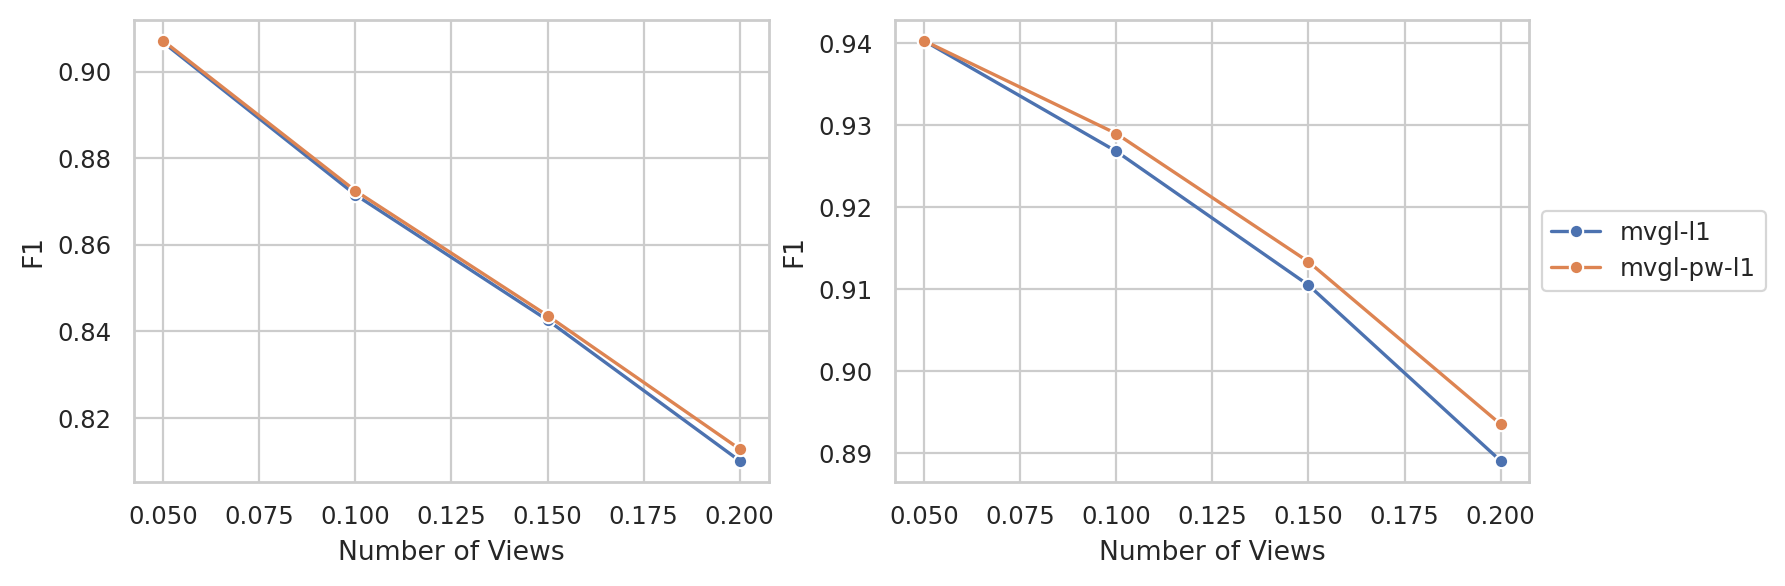

In [44]:
metric = "F1"
graph_model = "er"

methods = ["mvgl-l1", "mvgl-pw-l1"]
fltr = "gaussian"

performances = []
for method in methods:
    for n_signals in np.arange(0.05, 0.21, 0.05):
        exp_file = f"revision-exp3-{graph_model}-{n_signals:.2f}-{fltr}"
        save_path = Path(
            mvgl.ROOT_DIR, "data", "simulations", "outputs",
            exp_file, 
        )
        save_file = Path(save_path, f"{method}.csv")

        perf = pd.read_csv(save_file, index_col=0)
        perf["Varying"] = n_signals

        # if method.startswith("jemgl"):
        #     diff = 100
        #     for _, group in perf.groupby("Similarity"):
        #         curr_diff = np.abs(group.iloc[0]["LearnedSimilarity"] - 0.8)
        #         if curr_diff < diff:
        #             perf = group 
        #             diff = curr_diff    
        # else:
        #     perf = perf[perf.Similarity == 0.8]

        performances.append(perf)

performances = pd.concat(performances)

performances["index"] = np.arange(len(performances))
grouped = performances.groupby(["Run", "Method", "Varying"], as_index=False)

view_indices = []
consensus_indices = []
for i, group in grouped:
    view_perf = group[group["Graph"] == "view"]
    best_indx = np.argmax(view_perf[metric])
    view_indices.append(view_perf.iloc[best_indx]["index"])
    if i[1] in ["mvgl-l1", "mvgl-l2"]:
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 1) 
    elif i[1] == "mvgl-pw-l2":
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 1) # Mean
    elif i[1] == "mvgl-pw-l1":
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 2) # Median
    else:
        consensus_indices.append(view_perf.iloc[best_indx]["index"] + 2)

view_perf = performances.iloc[view_indices, :]
consensus_perf = performances.iloc[consensus_indices, :]

fig, axs = plt.subplots(ncols=2, figsize=(9, 3))

ax = axs[0]
sns.lineplot(view_perf, x="Varying", y=metric, hue="Method", marker="o", 
             ax = ax, errorbar=None)
ax.legend().remove()
ax.set_xlabel("Number of Views")
#ax.set_xticks([3, 4, 5, 6]);

ax = axs[1]
sns.lineplot(consensus_perf, x="Varying", y=metric, hue="Method", marker="o", 
             ax = ax, errorbar=None)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Number of Views")
# ax.set_xticks([3, 4, 5, 6]);